In [1]:
import logging, os, pickle
import requests, glob
from datetime import datetime
from bs4 import BeautifulSoup
from datetime import datetime
import pandas as pd
import time
from datetime import date
import urllib.request
from selenium.webdriver import Chrome
import json, re, sys, h5py
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
import datetime as dt
import pymysql
import matplotlib.pyplot as plt
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from pykrx import stock
import warnings
warnings.filterwarnings(action='ignore')
import shutil
from matplotlib.pyplot import cm
import numpy as np

In [2]:
import Loader
ldr = Loader.Loader()
conn = pymysql.connect(host='localhost',user='root',
                                   password='tlqkfdk2',db='INVESTAR',charset='utf8')

In [3]:
def GetExpectedReturn(df):
    return (df - df.iloc[0,:]) / df.iloc[0,:]

In [4]:
def Filtering(dt, conn, by=None):
    code_ls = list(pd.read_sql("select code from company_info",conn).code.values)
    """Basic Filtering"""
    # 자본 총계가 하위 50% or 연평균(?합?) 거래량이 하위 30%
    tdf = pd.read_sql(f"select * from finance_info_copy where date='{dt}' and itm='자본총계'",conn)
    tdf = tdf[lambda x : x['value']!=-999.9].reset_index(drop=True)
    equity_half = tdf['value'].quantile(q=0.3, interpolation='nearest')
    equity_half_ls = set(tdf[lambda x : x['value']<=equity_half].code.values)
    code_ls = list(set(code_ls) - equity_half_ls)
    
    df = pd.read_sql(f"select code, date, volume from daily_price where date between '{dt[:4]+'-01-01'}' and '{dt[:4]+'-12-31'}'",conn)
    volume_30 = df.groupby(by='code').mean()['volume'].quantile(q=0.2,interpolation='nearest')
    volume_30_ls = set(df[lambda x : x['volume']<=volume_30].code.values)
    code_ls = list(set(code_ls) - volume_30_ls)
    
    if by == None :
        return code_ls
    else :
        for e in by :
            if e == 'PBR':
                df = pd.read_sql(f"select * from finance_info_copy where date='{dt}' and itm='PBR'",conn)
                code_ls = list(set(code_ls) - set(df[lambda x : x['value']<0].code.values))
            elif e == 'PCR':
                df = pd.read_sql(f"select * from finance_info_copy where date='{dt}' and itm='PCR'",conn)
                code_ls = list(set(code_ls) - set(df[lambda x : x['value']<0].code.values))
                df = pd.read_sql(f"select * from finance_info_copy where date='{dt}' and itm='영업활동현금흐름'",conn)
                code_ls = list(set(code_ls) - set(df[lambda x : x['value']<0].code.values))
                small_cfc = []
                for cd in list(set(df.code.values)):
                    try :
                        if df[(df.code==cd)]['value'].values[0] <= tdf[(tdf.code==cd)]['value'].values[0] * 0.01:
                            small_cfc.append(cd)
                    except :
                        pass
                code_ls = list(set(code_ls) - set(small_cfc))
            elif e == 'POR':
                df = pd.read_sql(f"select * from finance_info_copy where date='{dt}' and itm='POR'",conn)
                code_ls = list(set(code_ls) - set(df[lambda x : x['value']<0].code.values))
                df = pd.read_sql(f"select * from finance_info_copy where date='{dt}' and itm='영업이익'",conn)
                code_ls = list(set(code_ls) - set(df[lambda x : x['value']<0].code.values))
                small_profit = []
                for cd in list(set(df.code.values)):
                    try :
                        if df[(df.code==cd)]['value'].values[0] <= tdf[(tdf.code==cd)]['value'].values[0] * 0.01:
                            small_profit.append(Cd)
                    except :
                        pass
                code_ls = list(set(code_ls) - set(small_profit))
            else :
                raise ValueError("Can't be !!")
        return code_ls

In [5]:
def VisualTest_Y_v2(dt, conn, cut=10, term=22, itm='PBR', unit='Y', filterby=['PBR','PCR','POR']):
    #ldr = Loader()
    code_ls = list(pd.read_sql("select code from company_info",conn).code.values)
    with open("./TradingDates.pickle", "rb") as fr:
        td_days = pickle.load(fr)
    """Finding start date"""
    cn = conn.cursor()
    cn.execute("select max(date) from daily_price where code='005930'")
    last_update = cn.fetchone()[0].strftime("%Y-%m-%d")
    start=''
    end=''
    date_ls=[]
    if unit == 'Y':
        next_year = str(int(dt[:4])+1)
        for td in td_days:
            if td >= next_year+'-01-01':
                if td <= next_year+'-03-03':
                    start = td
                elif td <= str(int(next_year)+1)+'-03-03' and td <= last_update:
                    end = td
                else :
                    break
        pointer = td_days.index(start)
        while (pointer <= td_days.index(end)):
            date_ls.append(td_days[pointer])
            pointer += term
    elif unit == 'Q':
        print("Not implemented yet.")
        pass
    else :
        raise ValueError("Can't be..")
               
    print("Start Date : ",start)
    #print("Dates : ",date_ls)
    sub_ls = Filtering(dt, conn, by=filterby)
    #start_dt = str(int(dt[:4])+1)+'-01-01'
    #end_dt = str(int(dt[:4])+1)+'-12-31'
    
    fn_df = ldr.GetFinance(dt[:4]+'-01-01', dt+'-31', item=itm, code_ls=sub_ls, unit='Y', colname='code')
    fn_df.dropna(axis=1, inplace=True)
    #pr_df = ldr.GetPrice(Q1, Q5, sub_ls, item='adjprice',colname='code')
    pr_df = ldr.GetPricePerTerm(date_ls, sub_ls, item='adjprice',colname='code')
               
    #pr_df = pr_df[pr_df.index.isin([Q1,Q2,Q3,Q4,Q5])]
    pr_df.dropna(axis=1, inplace=True)
    sub_ls = list(set(fn_df.columns).intersection(set(pr_df.columns)))
    print("Universe Size : ",len(sub_ls))
    fn_df = fn_df[sub_ls].T
    fn_df.rename({dt:"value"},axis=1,inplace=True)
    pr_df = pr_df[sub_ls]
    pr_df = GetExpectedReturn(pr_df).T
    pr_df.drop(columns=pr_df.columns[0],axis=1,inplace=True)
    total = pd.concat([fn_df,pr_df],axis=1)
    raw_df = total.copy()
    total = total.groupby(pd.qcut(total['value'],cut)).agg(['mean'])
    #print(total.columns)
    #print(date_ls)
    total.columns = ['value']+date_ls[1:]
    
    
    
    date_ls = date_ls[1:]
    """
    row_space = round(len(date_ls)/3)
    fig = plt.figure(figsize=(20,60))
    for i in range(len(date_ls)):
        #plt.subplot(row_space,2,i+1)
        ax = fig.add_subplot(row_space,3,1+i)
        plt.title("Expected Return at {} with {}".format(date_ls[i], itm))
        ax.scatter(total['value'],total[date_ls[i]],color='g')
        #plt.scatter(total['value'],total[date_ls[i]],color='g')

    plt.show()"""
    
    color=iter(cm.rainbow(np.linspace(0,1,cut)))
    plt.figure(figsize=(15,10))
    plt.title("Total Expected Return at some points with {}".format(itm))
    plt.xlabel(f"{itm} with {cut} quantile")
    plt.ylabel('Expected Return Rate')
    for i in range(cut):
        c = next(color)
        plt.plot(total.columns[1:], total.iloc[i,1:], color=c, marker='o', linestyle='--', label='{}-with-{}quantile'.format(itm,i+1))
    #plt.legend(loc='best')
    plt.legend(loc='upper left')
    plt.grid(True)           
    plt.show()
    
    tmp = pd.DataFrame(total.drop(['value'],axis=1).T.mean())
    tmp.columns = list(tmp.columns[:-1])+['mean']
    labels = [i+1 for i in range(len(total))]
    total['label']=labels
    total = pd.concat([total,tmp],axis=1)
    total.sort_values(by=['mean'],ascending=False,inplace=True)
    
    return total.iloc[:3,:]

In [6]:
def MultipleSubset(dt, univ, conn, cut=10, by=None):
    if by==None:
        by = ['PBR','PER','PCR','POR','PSR','ROE','ROA','EPS','BPS','시가총액']
    total = pd.DataFrame(index=univ)
    #total['code'] = univ
    for itm in by :
        df = pd.read_sql(f"select code, value from finance_info_copy where code in {tuple(univ)} and date='{dt}' and itm='{itm}'",conn)
        df.index = df.code
        df.drop(['code'],axis=1,inplace=True)
        sub = pd.DataFrame((pd.qcut(df['value'],cut)))
        tmp = df.groupby(pd.qcut(df['value'],cut)).agg(['mean'])
        dct = {}
        for ith, itvl in enumerate(tmp.index):
            dct[itvl] = ith + 1
        df[itm] = sub['value'].map(dct)
        
        total = pd.concat([total, df[[itm]]],axis=1)
    return total

---

In [32]:
%%time
dt = '2017-12'
ls_ftrp = Filtering(dt,conn, by=['PBR','PCR','POR'])
total = MultipleSubset(dt,ls_ftrp,conn,cut=5)

Wall time: 16.1 s


In [33]:
tt = total.dropna(axis=0,how='any')

In [36]:
qwe = tt.T
ct = []
for cl in qwe.columns:
    if len(set(qwe[cl].values))==3:
        ct.append(str(cl))

In [37]:
len(ct)

87

In [41]:
qwe[ct[2]]

PBR     1
PER     1
PCR     1
POR     1
PSR     1
ROE     4
ROA     3
EPS     3
BPS     3
시가총액    1
Name: 092780, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

---

Start Date :  2017-03-03
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  651


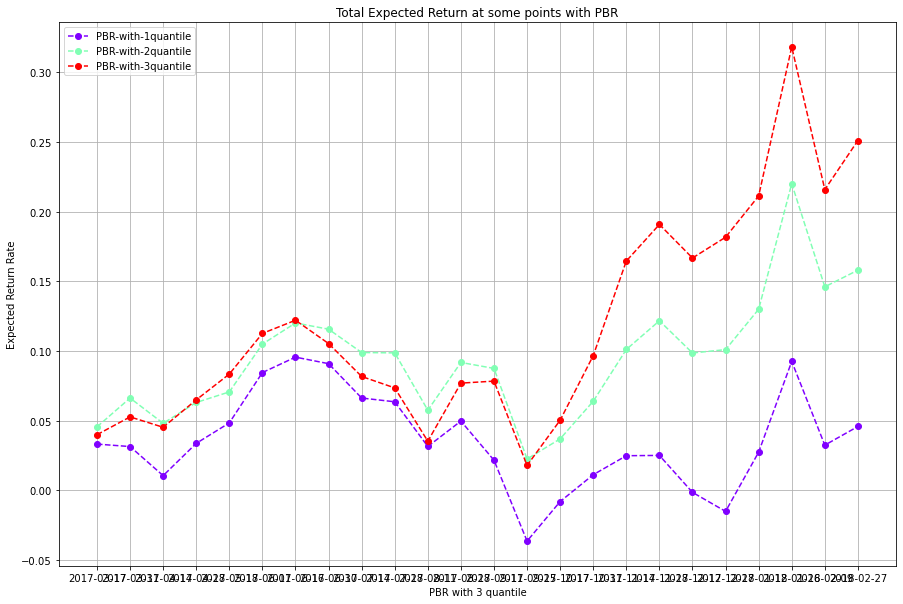

Start Date :  2018-03-02
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  309


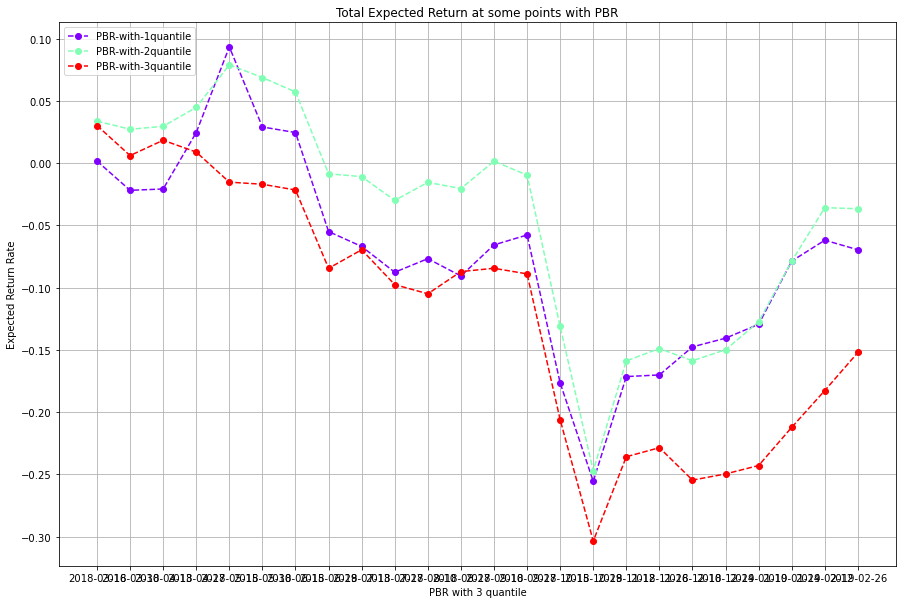

Start Date :  2019-02-28
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  243


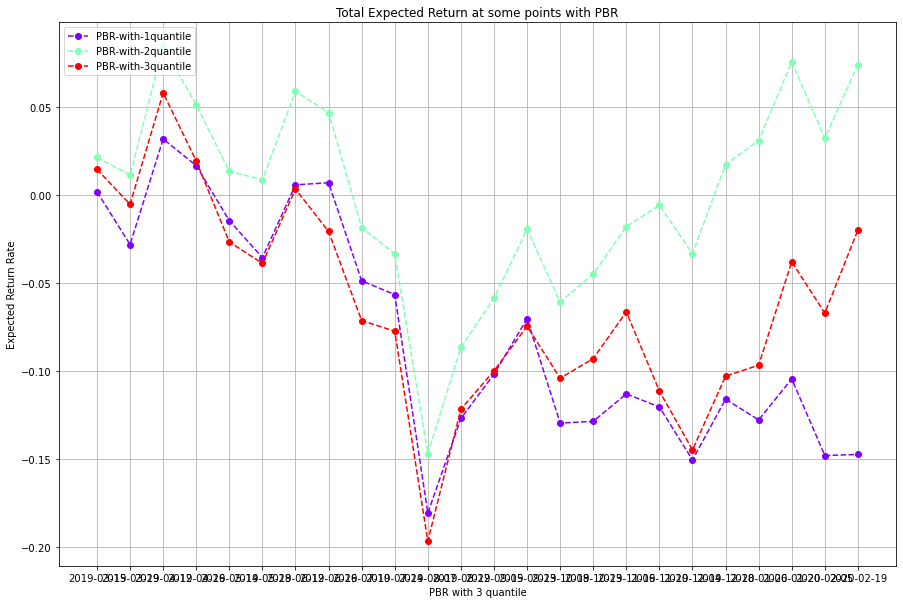

Start Date :  2020-03-03
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  219


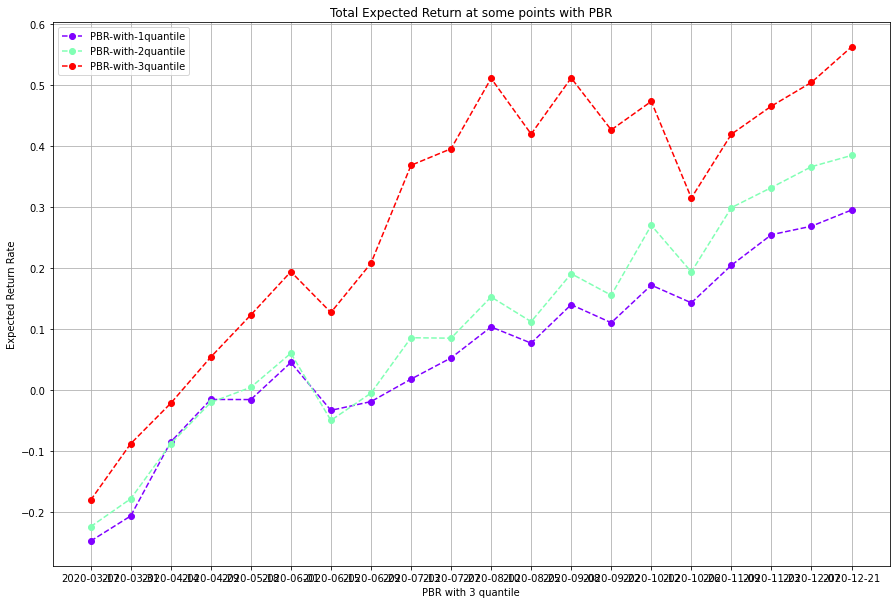

Wall time: 2min 34s


In [7]:
%%time
pbr11 = VisualTest_Y_v2('2016-12',conn,cut=3,term=10,itm='PBR',unit='Y')
pbr22 = VisualTest_Y_v2('2017-12',conn,cut=3,term=10,itm='PBR',unit='Y')
pbr33 = VisualTest_Y_v2('2018-12',conn,cut=3,term=10,itm='PBR',unit='Y')
pbr44 = VisualTest_Y_v2('2019-12',conn,cut=3,term=10,itm='PBR',unit='Y')

Start Date :  2017-03-03
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  651


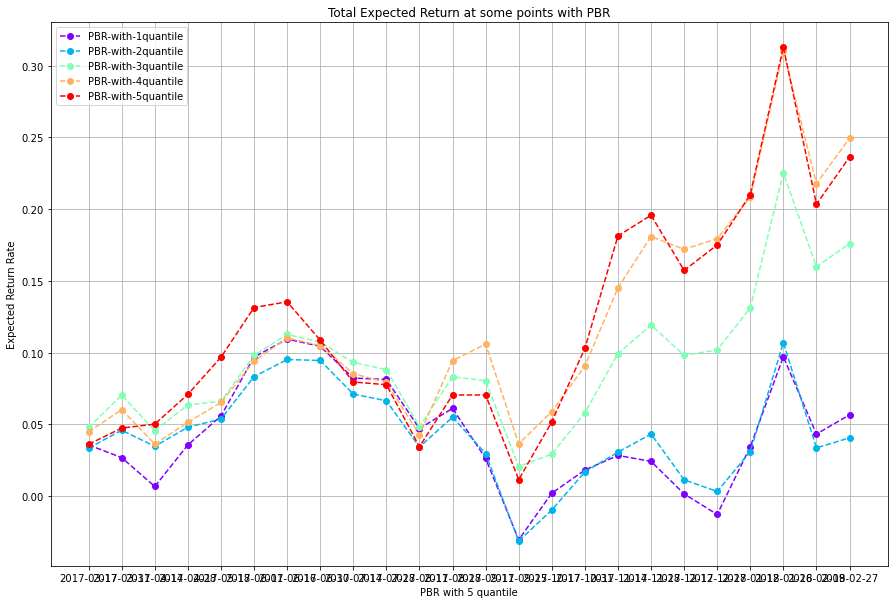

Start Date :  2018-03-02
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  309


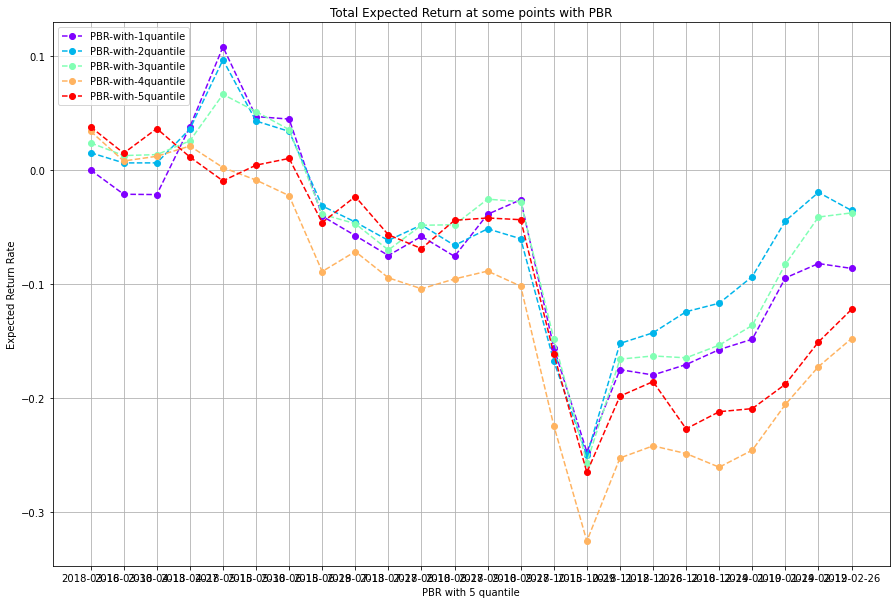

Start Date :  2019-02-28
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  243


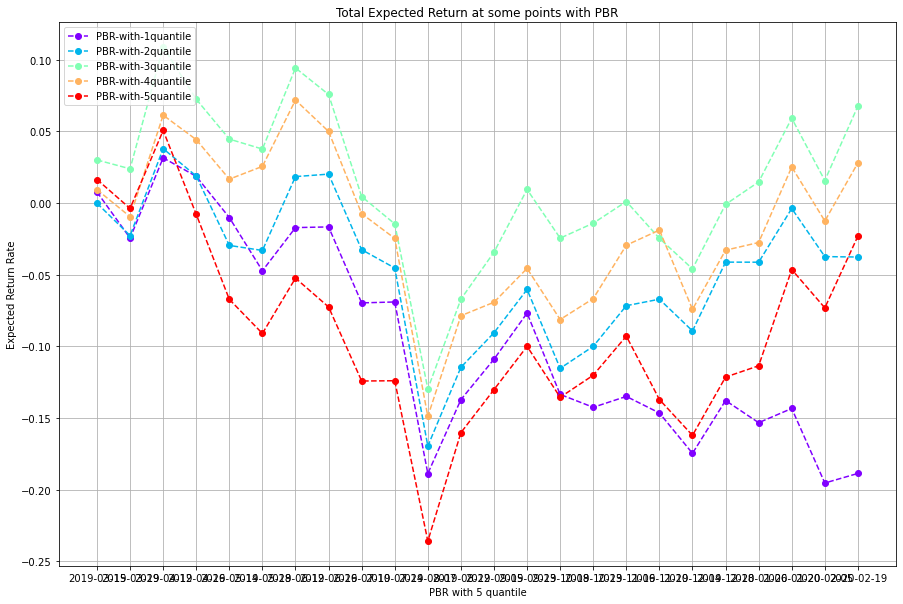

Start Date :  2020-03-03
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  219


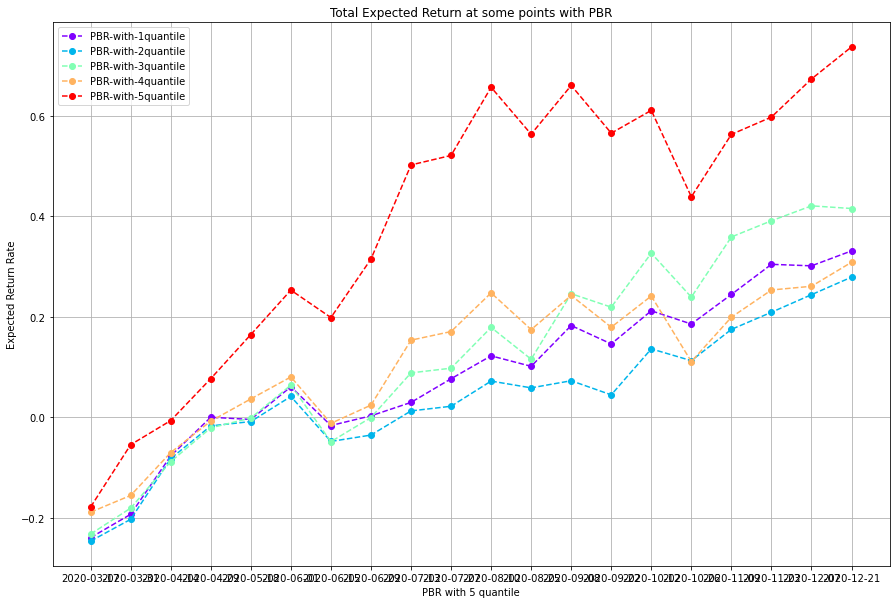

Wall time: 2min 31s


In [9]:
%%time
pbr11 = VisualTest_Y_v2('2016-12',conn,cut=5,term=10,itm='PBR',unit='Y')
pbr22 = VisualTest_Y_v2('2017-12',conn,cut=5,term=10,itm='PBR',unit='Y')
pbr33 = VisualTest_Y_v2('2018-12',conn,cut=5,term=10,itm='PBR',unit='Y')
pbr44 = VisualTest_Y_v2('2019-12',conn,cut=5,term=10,itm='PBR',unit='Y')

Start Date :  2017-03-03
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  650


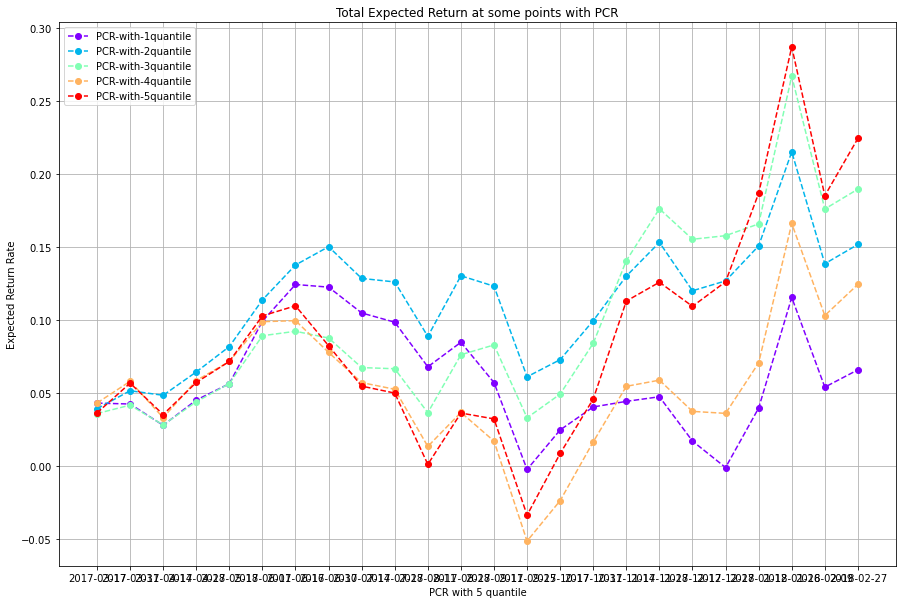

Start Date :  2018-03-02
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  309


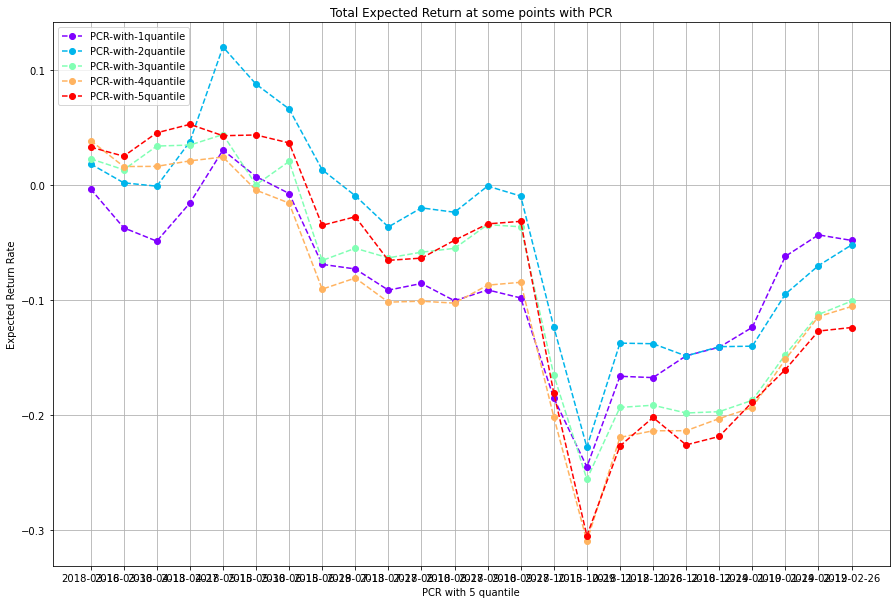

Start Date :  2019-02-28
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  243


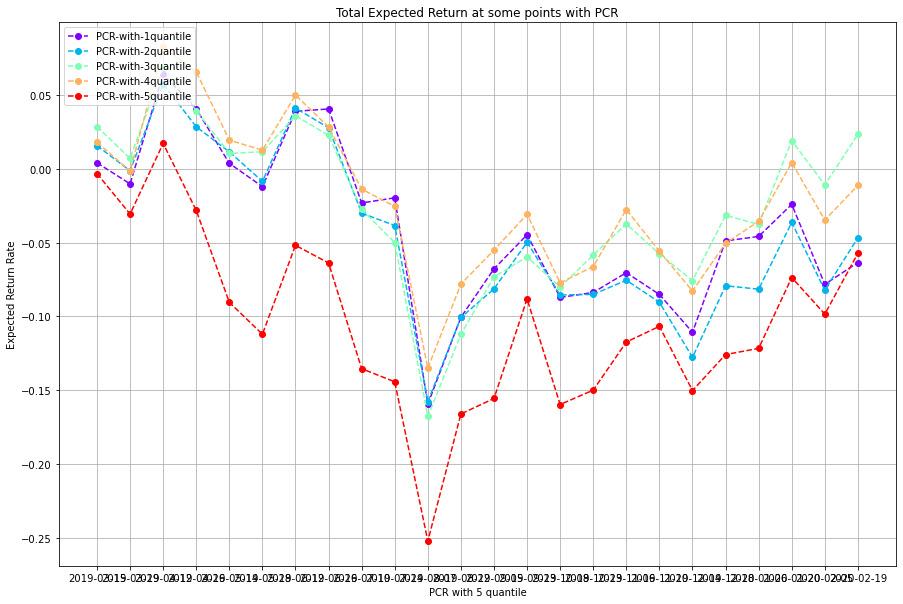

Start Date :  2020-03-03
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  219


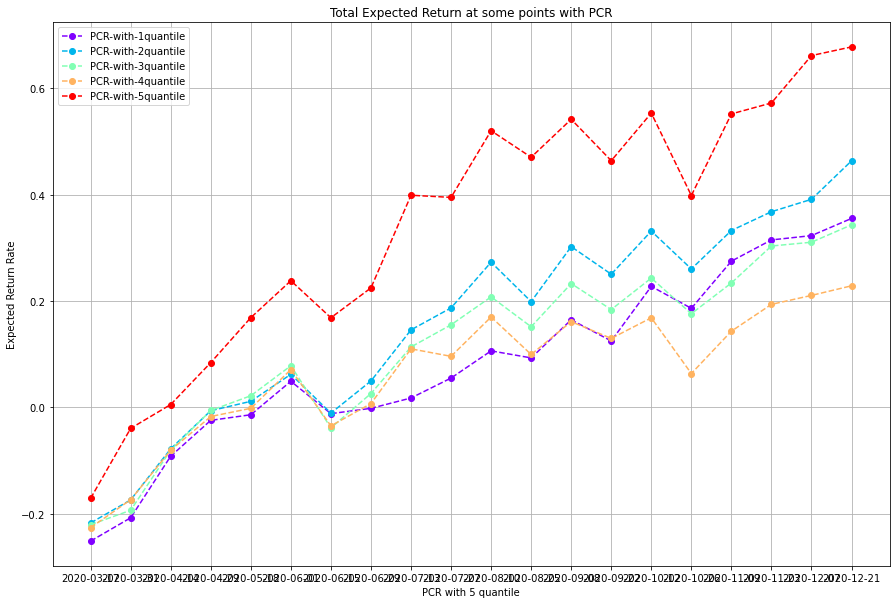

Wall time: 2min 38s


In [10]:
%%time
pcr11 = VisualTest_Y_v2('2016-12',conn,cut=5,term=10,itm='PCR',unit='Y')
pcr22 = VisualTest_Y_v2('2017-12',conn,cut=5,term=10,itm='PCR',unit='Y')
pcr33 = VisualTest_Y_v2('2018-12',conn,cut=5,term=10,itm='PCR',unit='Y')
pcr44 = VisualTest_Y_v2('2019-12',conn,cut=5,term=10,itm='PCR',unit='Y')

Start Date :  2017-03-03
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  650


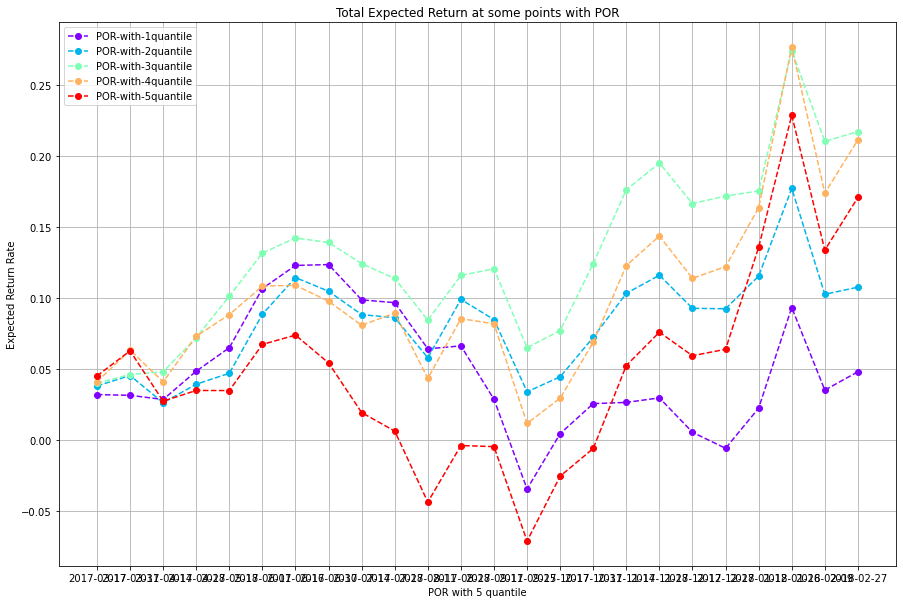

Start Date :  2018-03-02
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  309


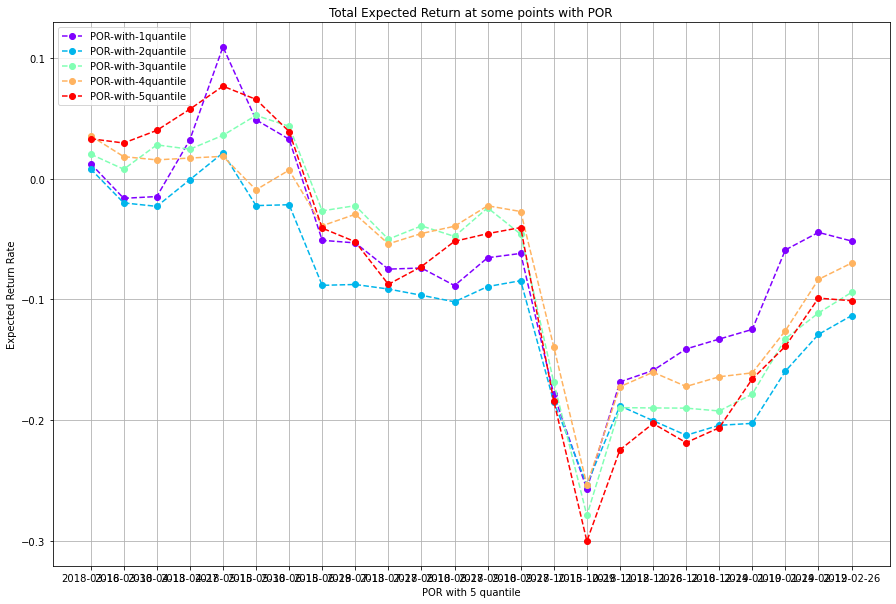

Start Date :  2019-02-28
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  243


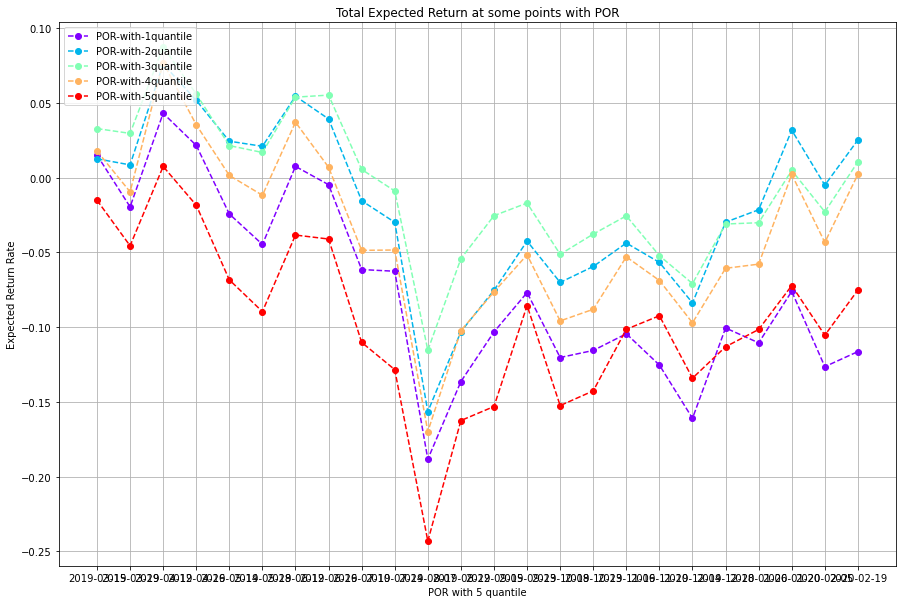

Start Date :  2020-03-03
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  219


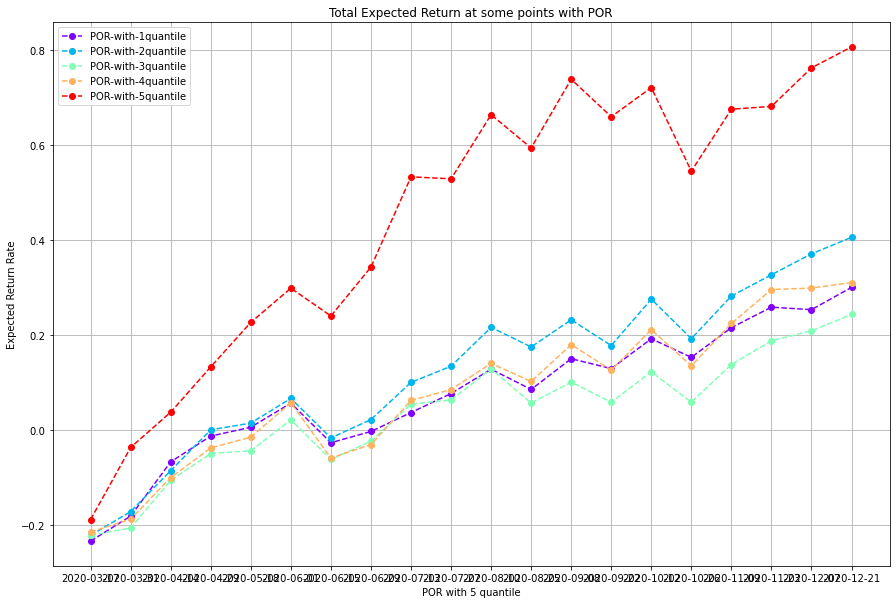

Wall time: 2min 36s


In [11]:
%%time
POR11 = VisualTest_Y_v2('2016-12',conn,cut=5,term=10,itm='POR',unit='Y')
POR22 = VisualTest_Y_v2('2017-12',conn,cut=5,term=10,itm='POR',unit='Y')
POR33 = VisualTest_Y_v2('2018-12',conn,cut=5,term=10,itm='POR',unit='Y')
POR44 = VisualTest_Y_v2('2019-12',conn,cut=5,term=10,itm='POR',unit='Y')

Start Date :  2017-03-03
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  650


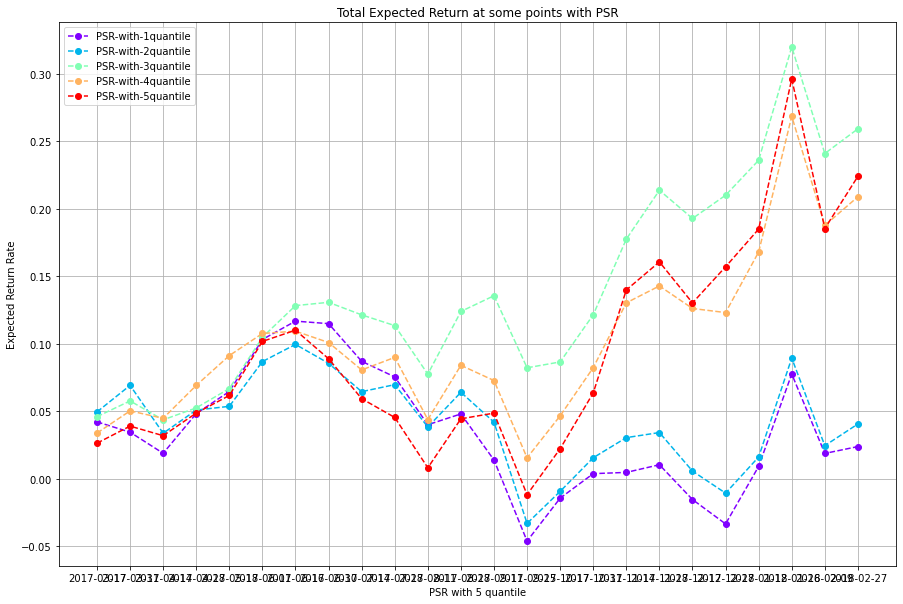

Start Date :  2018-03-02
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  309


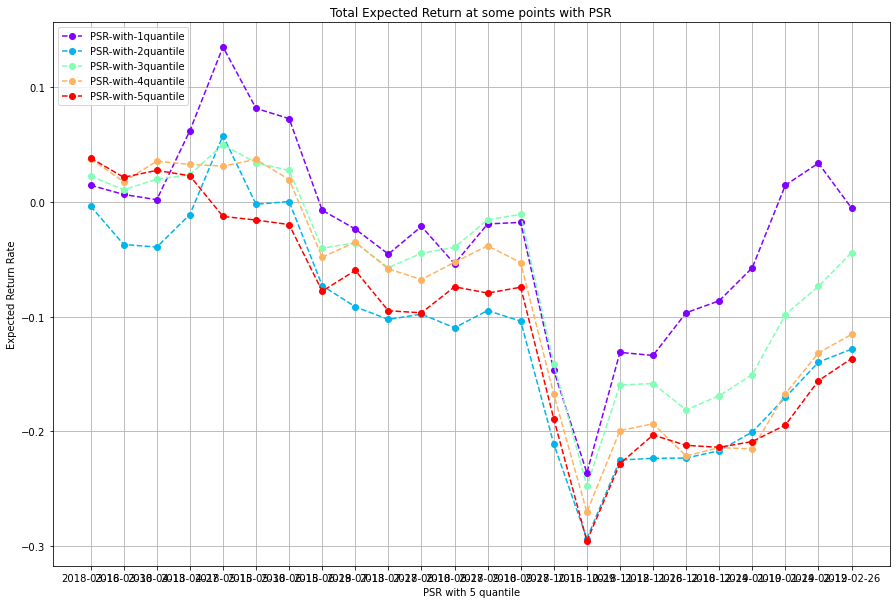

Start Date :  2019-02-28
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  243


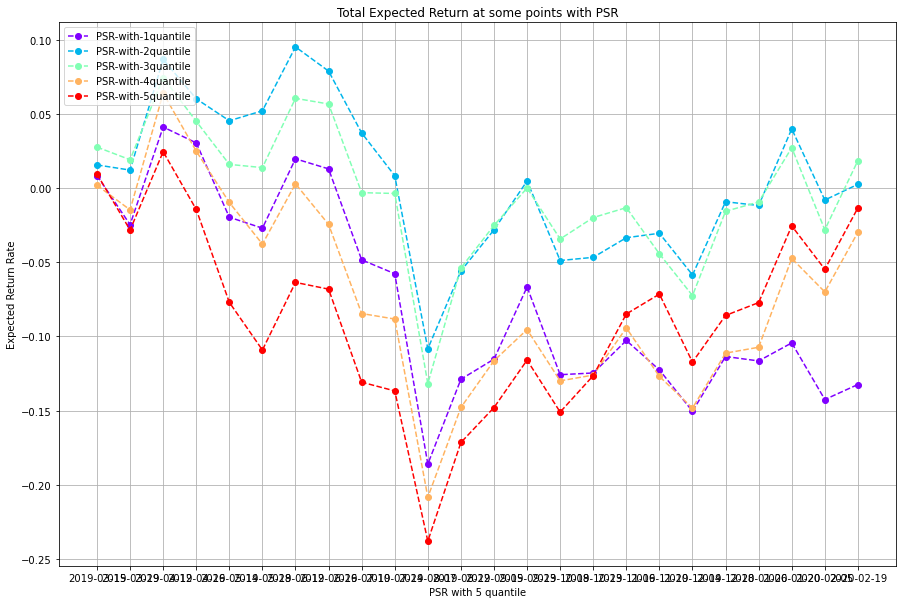

Start Date :  2020-03-03
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  219


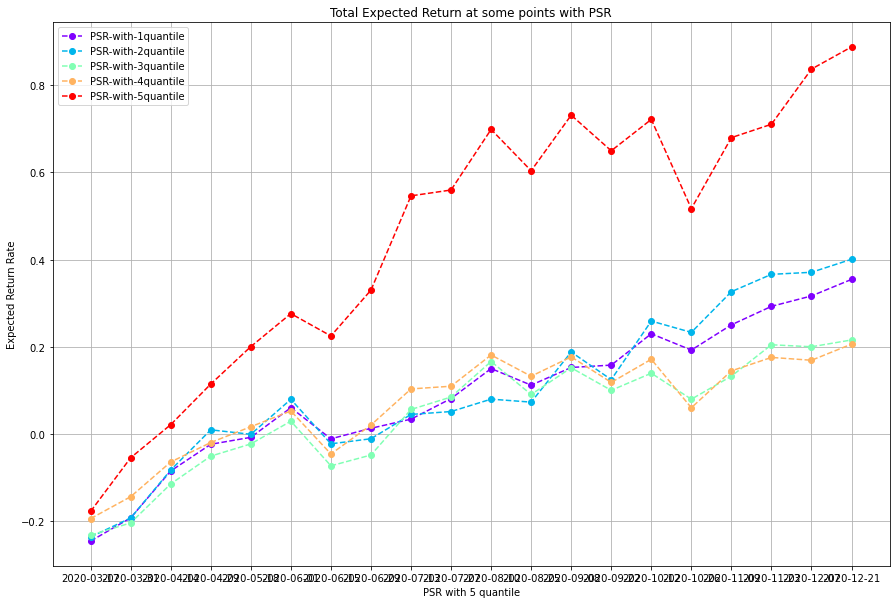

Wall time: 2min 32s


In [58]:
%%time
PSR11 = VisualTest_Y_v2('2016-12',conn,cut=5,term=10,itm='PSR',unit='Y')
PSR22 = VisualTest_Y_v2('2017-12',conn,cut=5,term=10,itm='PSR',unit='Y')
PSR33 = VisualTest_Y_v2('2018-12',conn,cut=5,term=10,itm='PSR',unit='Y')
PSR44 = VisualTest_Y_v2('2019-12',conn,cut=5,term=10,itm='PSR',unit='Y')

Start Date :  2017-03-03
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  650


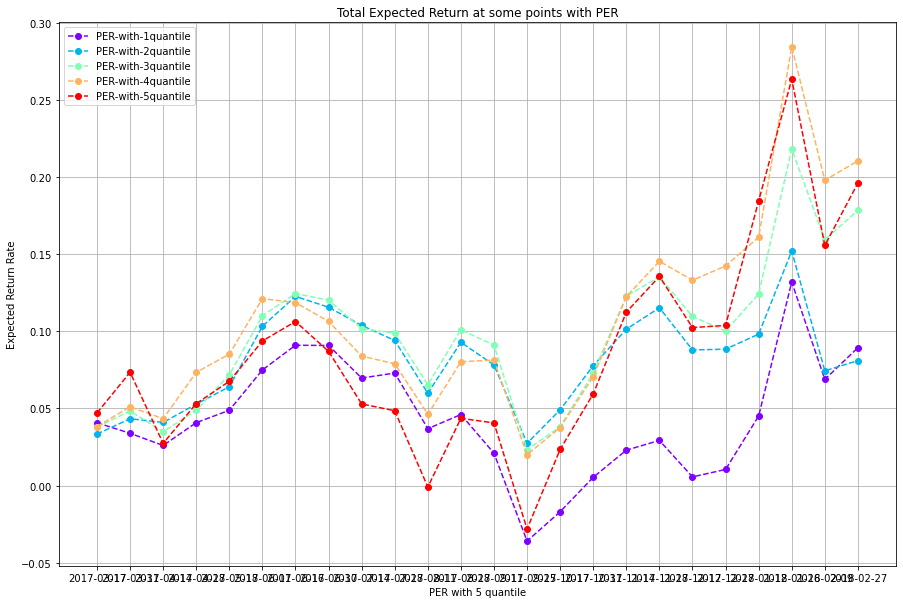

Start Date :  2018-03-02
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  309


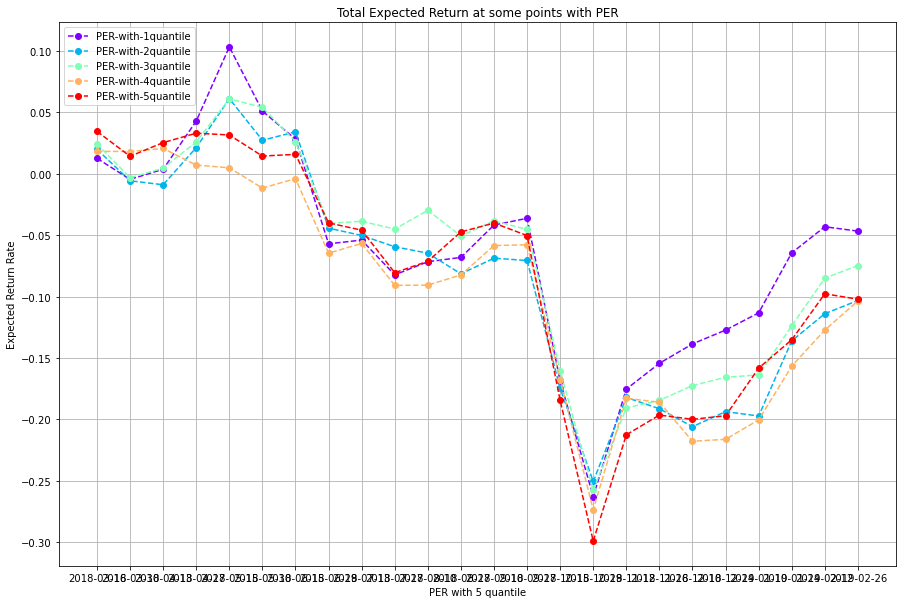

Start Date :  2019-02-28
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  243


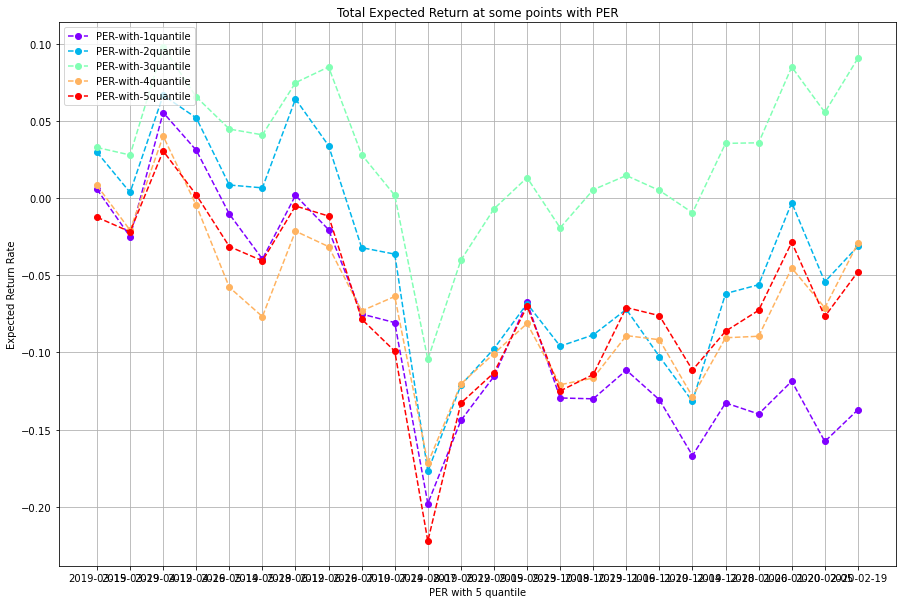

Start Date :  2020-03-03
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  219


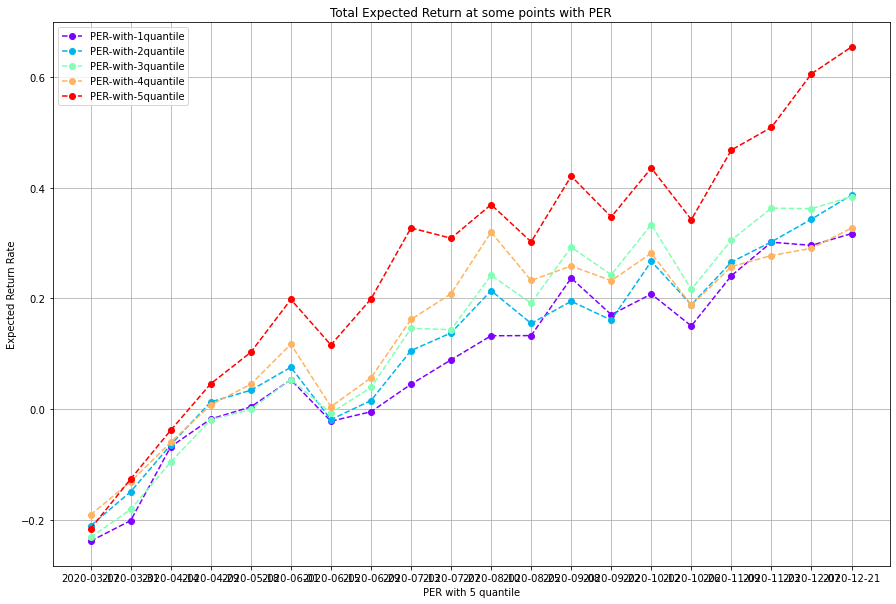

Wall time: 2min 33s


In [59]:
%%time
PER11 = VisualTest_Y_v2('2016-12',conn,cut=5,term=10,itm='PER',unit='Y')
PER22 = VisualTest_Y_v2('2017-12',conn,cut=5,term=10,itm='PER',unit='Y')
PER33 = VisualTest_Y_v2('2018-12',conn,cut=5,term=10,itm='PER',unit='Y')
PER44 = VisualTest_Y_v2('2019-12',conn,cut=5,term=10,itm='PER',unit='Y')

Start Date :  2017-03-03
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  650


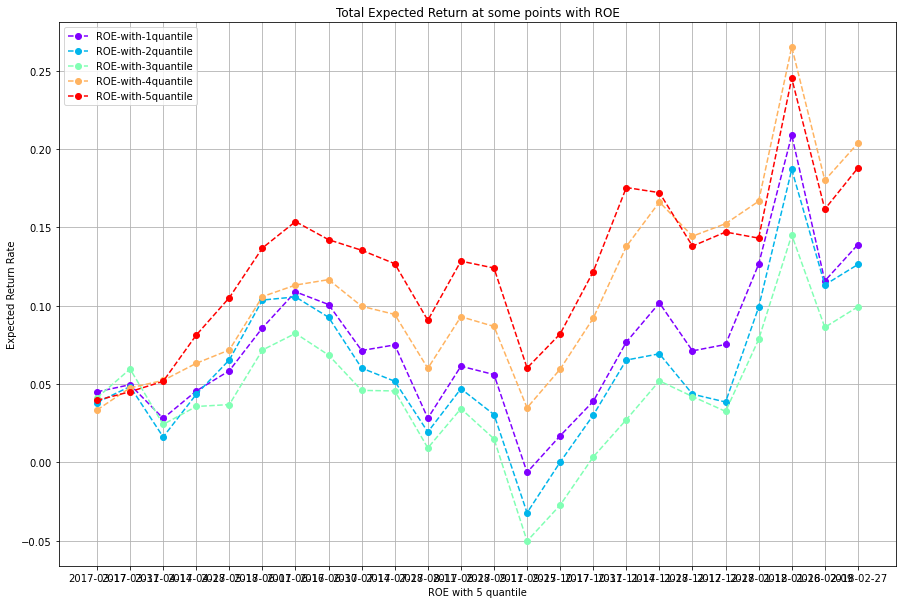

Start Date :  2018-03-02
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  309


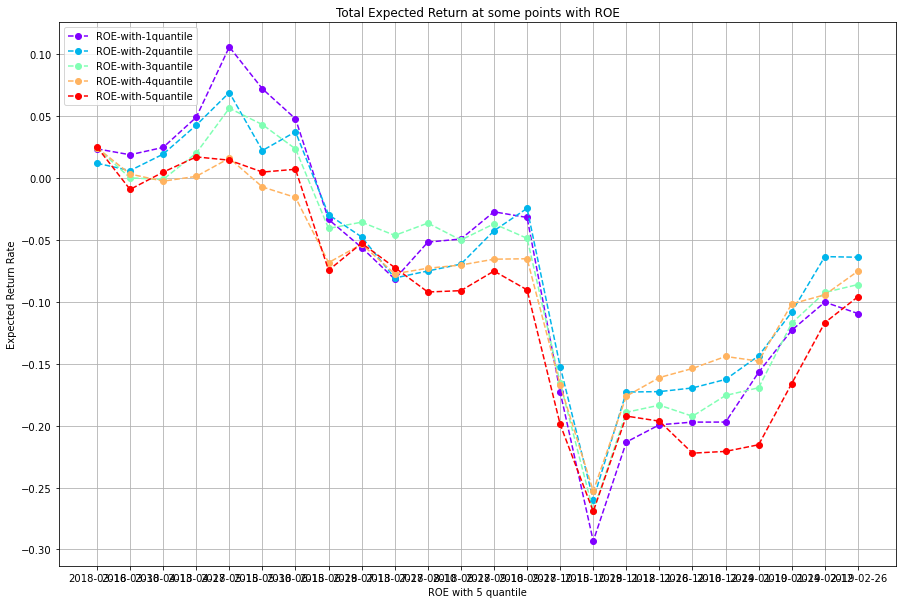

Start Date :  2019-02-28
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  243


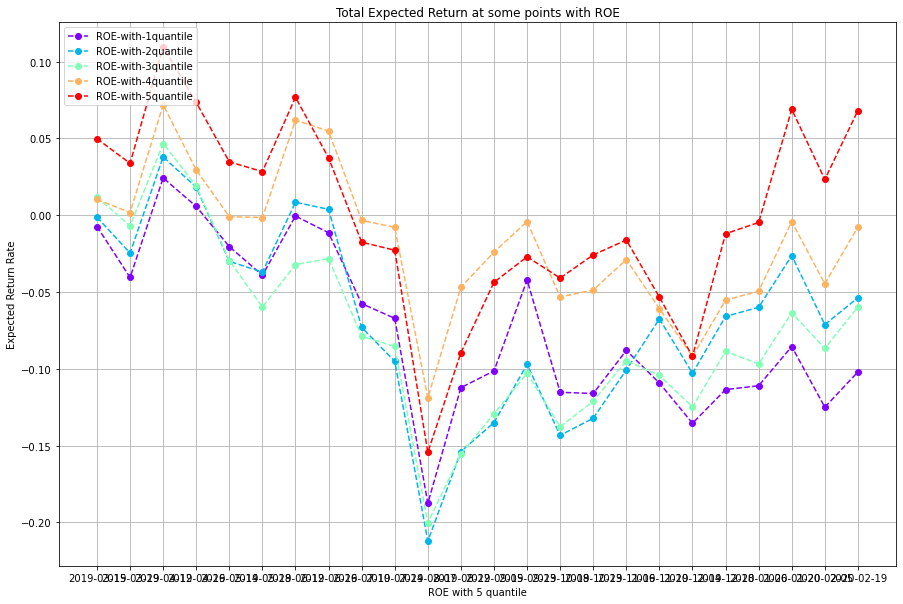

Start Date :  2020-03-03
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  219


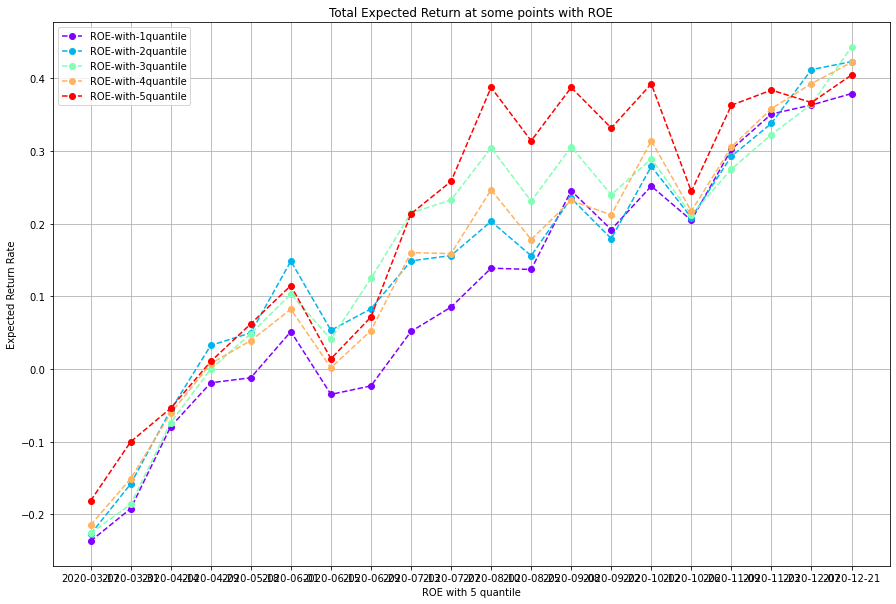

Wall time: 2min 35s


In [60]:
%%time
ROE11 = VisualTest_Y_v2('2016-12',conn,cut=5,term=10,itm='ROE',unit='Y')
ROE22 = VisualTest_Y_v2('2017-12',conn,cut=5,term=10,itm='ROE',unit='Y')
ROE33 = VisualTest_Y_v2('2018-12',conn,cut=5,term=10,itm='ROE',unit='Y')
ROE44 = VisualTest_Y_v2('2019-12',conn,cut=5,term=10,itm='ROE',unit='Y')

Start Date :  2017-03-03
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  650


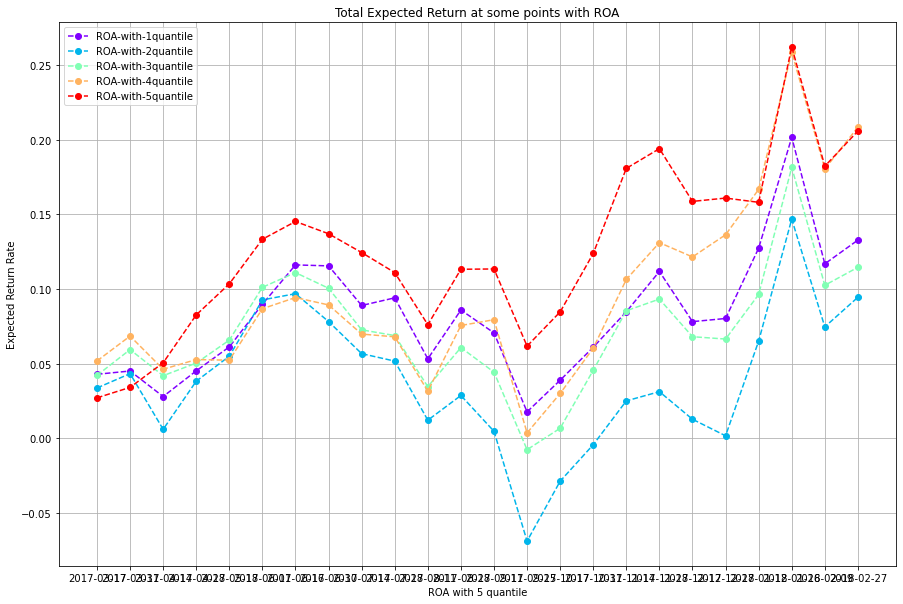

Start Date :  2018-03-02
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  309


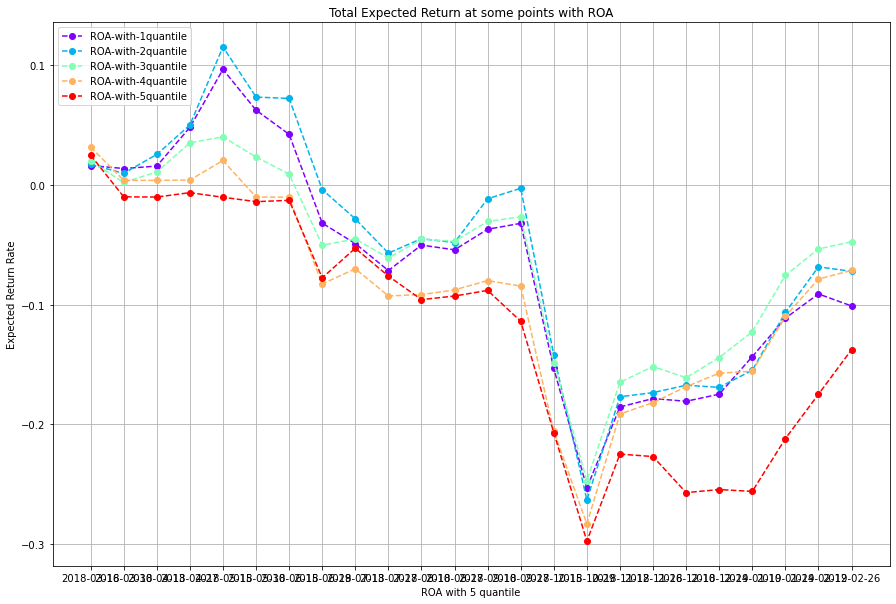

Start Date :  2019-02-28
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  243


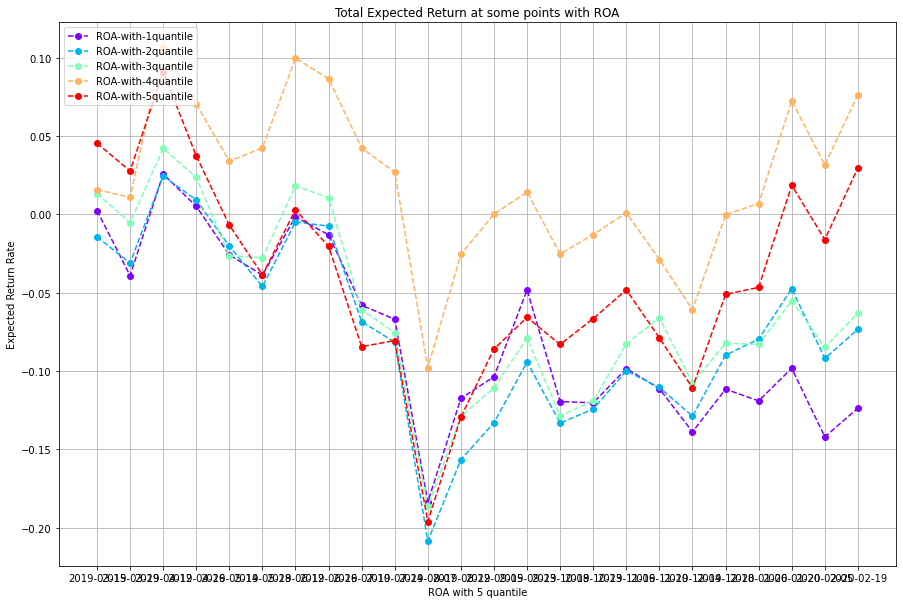

Start Date :  2020-03-03
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  219


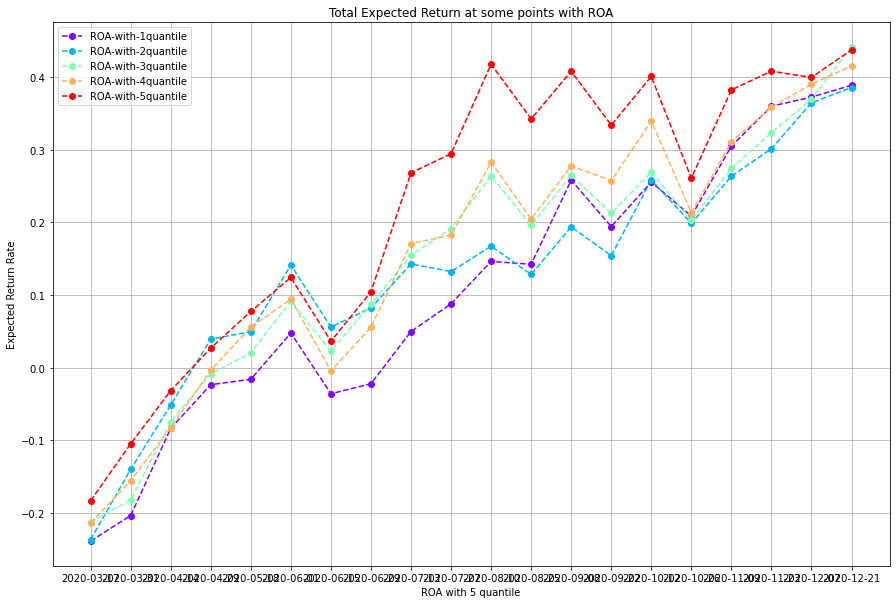

Wall time: 2min 57s


In [61]:
%%time
ROA11 = VisualTest_Y_v2('2016-12',conn,cut=5,term=10,itm='ROA',unit='Y')
ROA22 = VisualTest_Y_v2('2017-12',conn,cut=5,term=10,itm='ROA',unit='Y')
ROA33 = VisualTest_Y_v2('2018-12',conn,cut=5,term=10,itm='ROA',unit='Y')
ROA44 = VisualTest_Y_v2('2019-12',conn,cut=5,term=10,itm='ROA',unit='Y')

Start Date :  2017-03-03
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  650


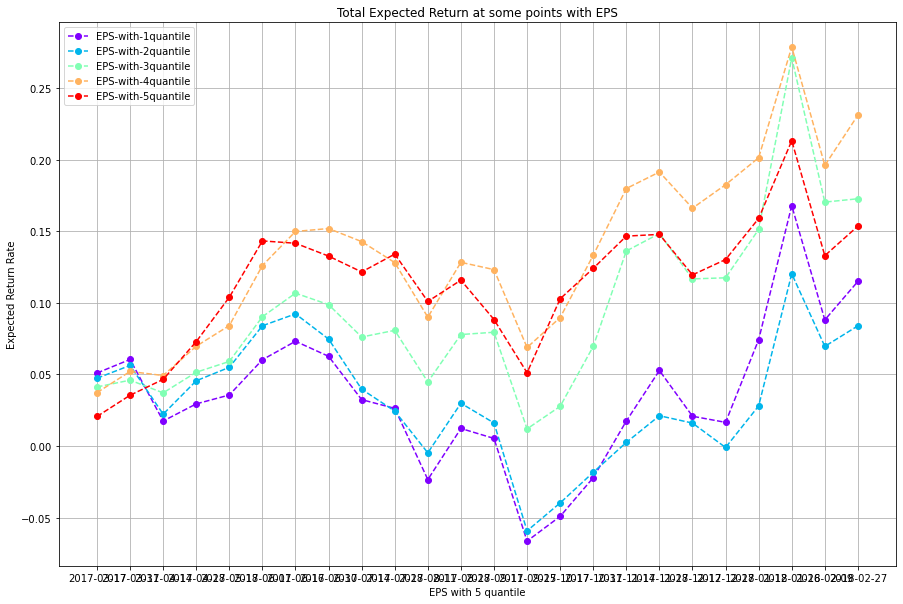

Start Date :  2018-03-02
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  309


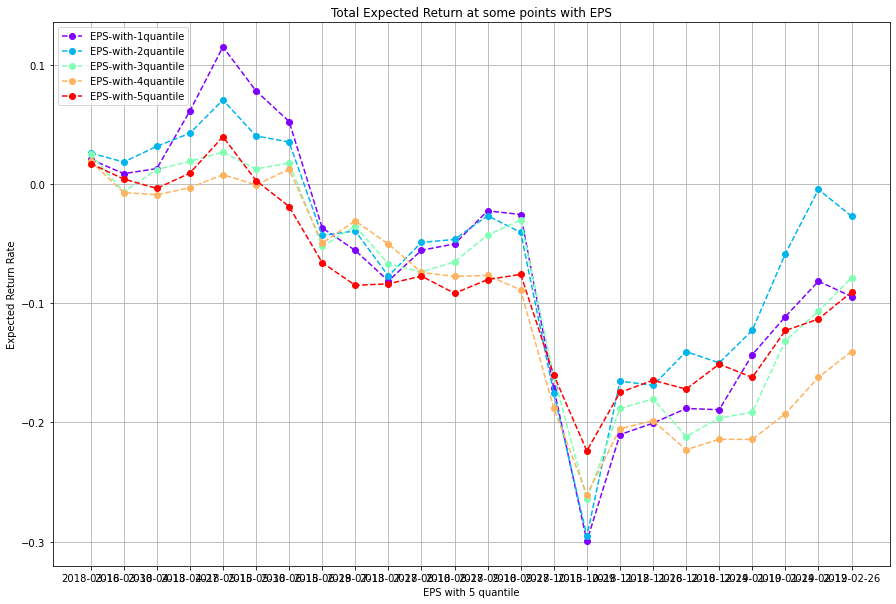

Start Date :  2019-02-28
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  243


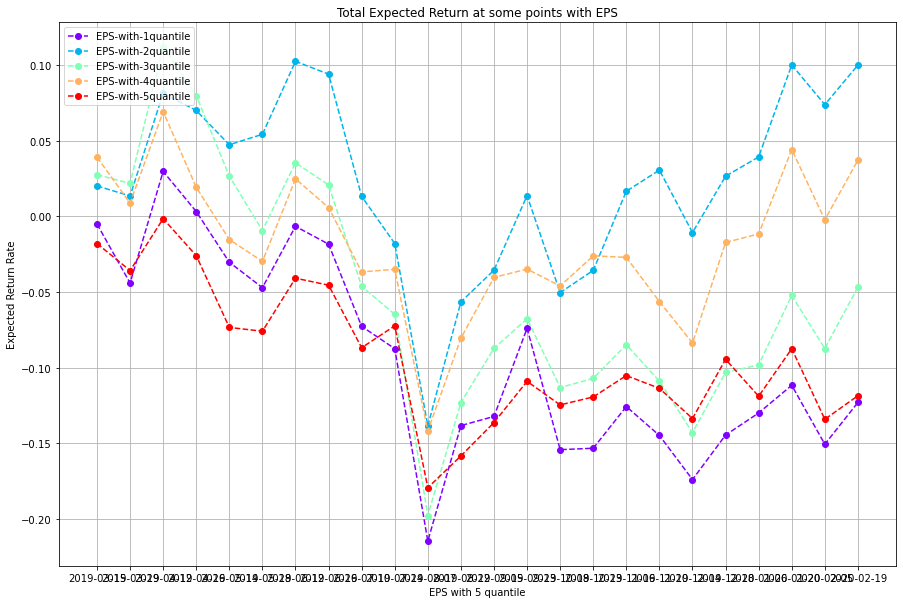

Start Date :  2020-03-03
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  219


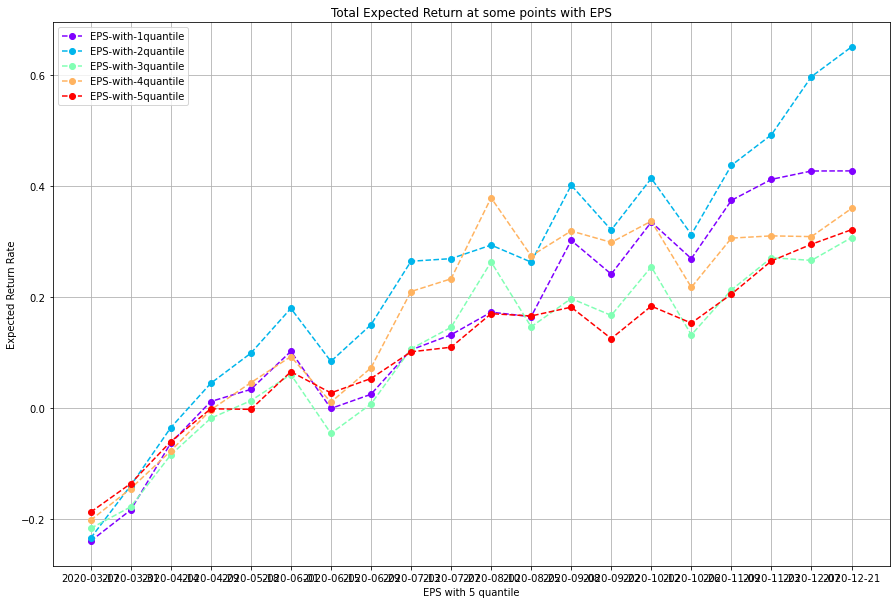

Wall time: 2min 56s


In [62]:
%%time
EPS11 = VisualTest_Y_v2('2016-12',conn,cut=5,term=10,itm='EPS',unit='Y')
EPS22 = VisualTest_Y_v2('2017-12',conn,cut=5,term=10,itm='EPS',unit='Y')
EPS33 = VisualTest_Y_v2('2018-12',conn,cut=5,term=10,itm='EPS',unit='Y')
EPS44 = VisualTest_Y_v2('2019-12',conn,cut=5,term=10,itm='EPS',unit='Y')

Start Date :  2017-03-03
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  650


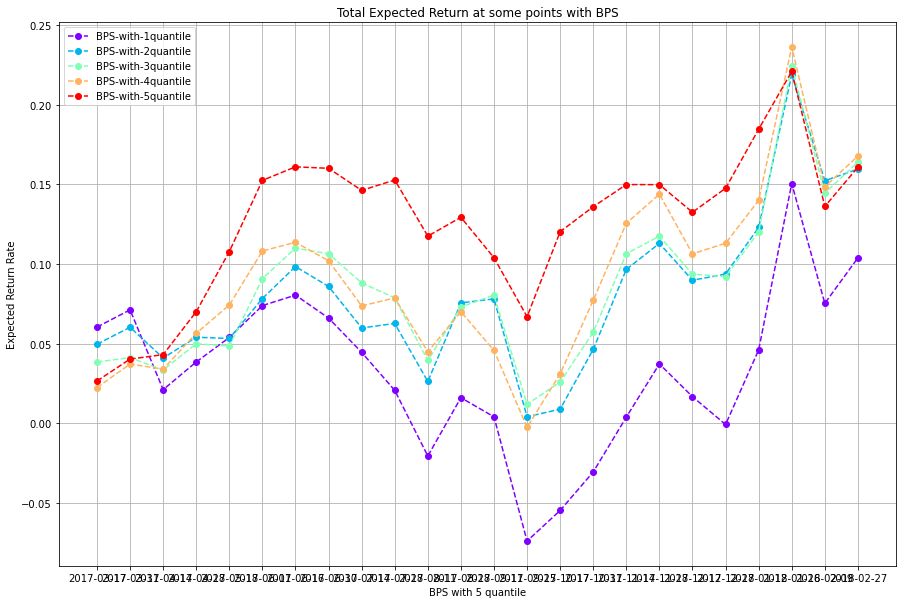

Start Date :  2018-03-02
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  309


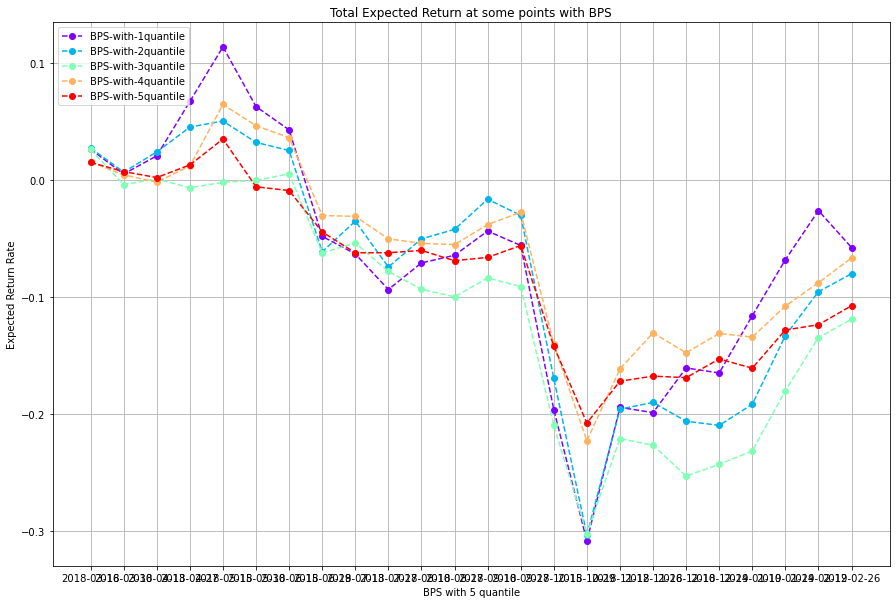

Start Date :  2019-02-28
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  243


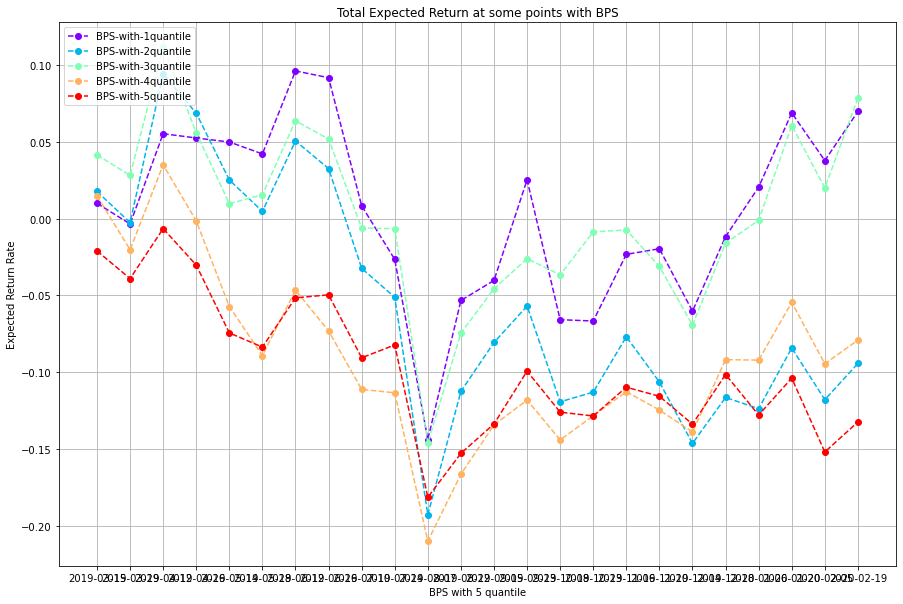

Start Date :  2020-03-03
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  219


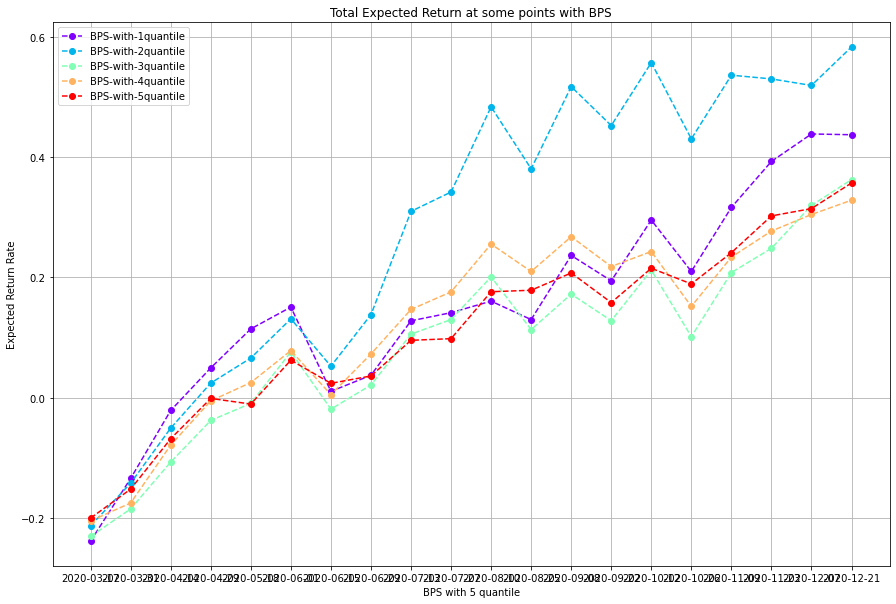

Wall time: 2min 50s


In [63]:
%%time
BPS11 = VisualTest_Y_v2('2016-12',conn,cut=5,term=10,itm='BPS',unit='Y')
BPS22 = VisualTest_Y_v2('2017-12',conn,cut=5,term=10,itm='BPS',unit='Y')
BPS33 = VisualTest_Y_v2('2018-12',conn,cut=5,term=10,itm='BPS',unit='Y')
BPS44 = VisualTest_Y_v2('2019-12',conn,cut=5,term=10,itm='BPS',unit='Y')

Start Date :  2017-03-03
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  674


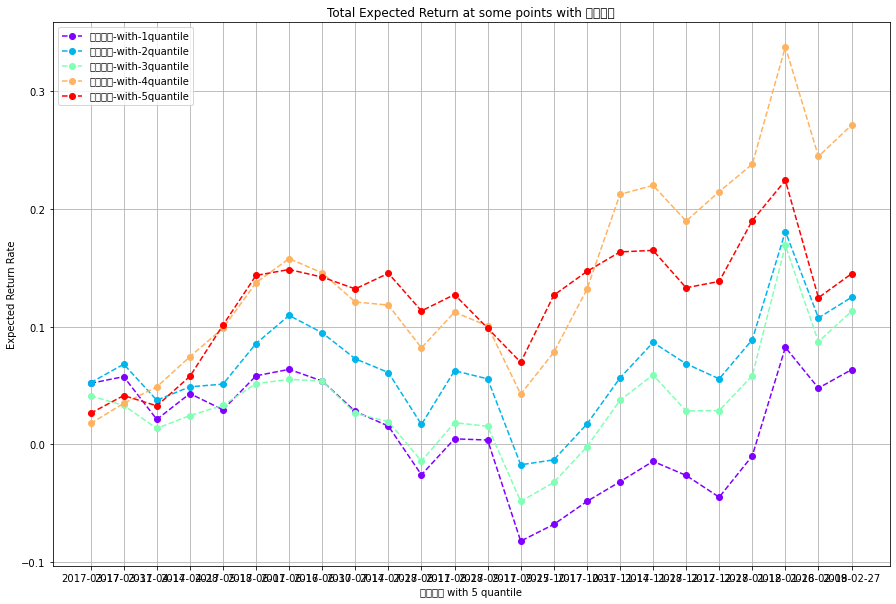

Start Date :  2018-03-02
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  320


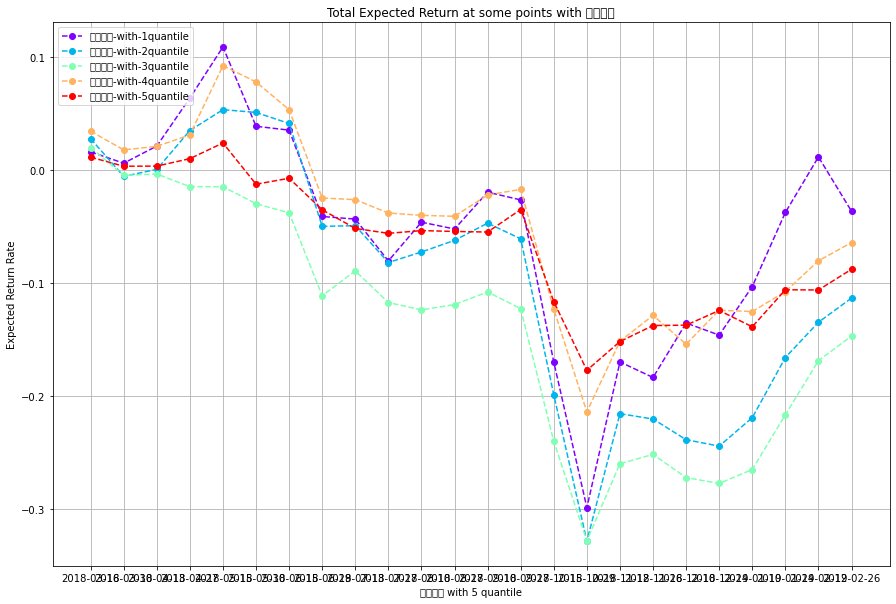

Start Date :  2019-02-28
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  258


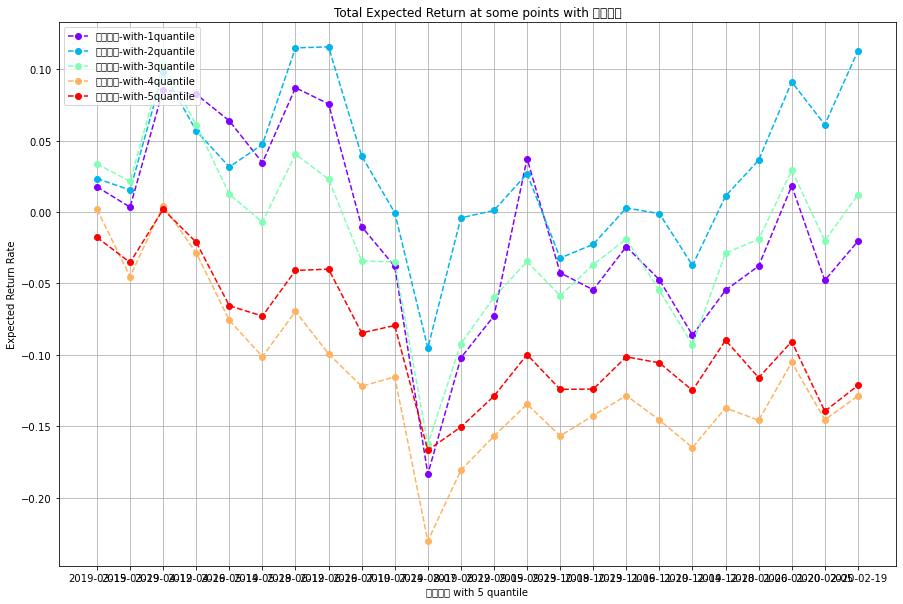

Start Date :  2020-03-03
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  224


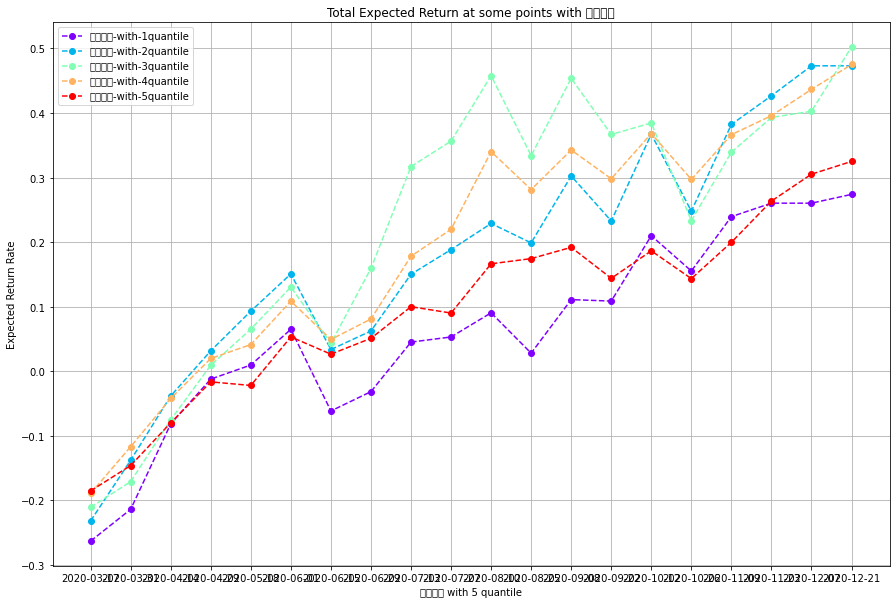

Wall time: 2min 49s


In [64]:
%%time
mcp11 = VisualTest_Y_v2('2016-12',conn,cut=5,term=10,itm='시가총액',unit='Y')
mcp22 = VisualTest_Y_v2('2017-12',conn,cut=5,term=10,itm='시가총액',unit='Y')
mcp33 = VisualTest_Y_v2('2018-12',conn,cut=5,term=10,itm='시가총액',unit='Y')
mcp44 = VisualTest_Y_v2('2019-12',conn,cut=5,term=10,itm='시가총액',unit='Y')

In [65]:
pbr44

value  2020-03-17  2020-03-31  2020-04-14  2020-04-29  \
value                                                                      
(2.084, 7.991]  3.432993   -0.178585   -0.054692   -0.006689    0.076750   
(0.929, 1.369]  1.162808   -0.232462   -0.180808   -0.088341   -0.021156   
(1.369, 2.084]  1.715221   -0.188896   -0.155589   -0.070316   -0.007792   

                2020-05-18  2020-06-01  2020-06-15  2020-06-29  2020-07-13  \
value                                                                        
(2.084, 7.991]    0.164391    0.252820    0.198266    0.314537    0.501845   
(0.929, 1.369]   -0.001609    0.063853   -0.048626   -0.000630    0.088217   
(1.369, 2.084]    0.036401    0.080102   -0.012238    0.024030    0.153266   

                ...  2020-09-08  2020-09-22  2020-10-12  2020-10-26  \
value           ...                                                   
(2.084, 7.991]  ...    0.659939    0.565074    0.610370    0.438454   
(0.929, 1.369]  ...    0.245680    0.218930    0.326326    0.238899   
(1.369, 2.084]  ...    0.242134    0.179031    0.241098    0.110653   

                2020-11-09  2020-11-23  2020-12-07  2020-12-21  label  \
value                                                                   
(2.084, 7.991]    0.562631    0.597071    0.672861    0.736635      5   
(0.929, 1.369]    0.358575    0.390777    0.420478    0.415177      3   
(1.369, 2.084]    0.198905    0.253095    0.260476    0.308229      4   

                    mean  
value                     
(2.084, 7.991]  0.392584  
(0.929, 1.369]  0.129242  
(1.369, 2.084]  0.112230  

[3 rows x 23 columns]

In [66]:
pbr44.iloc[0,1:-2]

2020-03-17   -0.178585
2020-03-31   -0.054692
2020-04-14   -0.006689
2020-04-29    0.076750
2020-05-18    0.164391
2020-06-01    0.252820
2020-06-15    0.198266
2020-06-29    0.314537
2020-07-13    0.501845
2020-07-27    0.520708
2020-08-10    0.656330
2020-08-25    0.562973
2020-09-08    0.659939
2020-09-22    0.565074
2020-10-12    0.610370
2020-10-26    0.438454
2020-11-09    0.562631
2020-11-23    0.597071
2020-12-07    0.672861
2020-12-21    0.736635
Name: (2.084, 7.991], dtype: float64

In [67]:
from scipy.stats.mstats import gmean

In [ ]:
df['Gmean'] = gmean(df.iloc[:,:3],axis=1)

In [71]:
gmean(pbr44.iloc[0,1:-2].values)

nan

In [73]:
np.exp(np.log(df.prod(axis=1))/df.notna().sum(1))

TypeError: return arrays must be of ArrayType

In [75]:
qwe = pbr11.drop(['value','label','mean'],axis=1)

In [81]:
np.exp(np.log(qwe.prod(axis=1))/qwe.notna().sum(1)).values

array([0.09391635, 0.09760478, 0.08123628])

In [80]:
pbr11[['mean']]

mean
value                    
(2.139, 19.277]  0.118593
(1.391, 2.139]   0.117588
(1.048, 1.391]   0.092568

In [121]:
def VisualTest_Y_v3(dt, conn, cut=10, term=22, itm='PBR', unit='Y', filterby=['PBR','PCR','POR']):
    #ldr = Loader()
    code_ls = list(pd.read_sql("select code from company_info",conn).code.values)
    with open("./TradingDates.pickle", "rb") as fr:
        td_days = pickle.load(fr)
    """Finding start date"""
    cn = conn.cursor()
    cn.execute("select max(date) from daily_price where code='005930'")
    last_update = cn.fetchone()[0].strftime("%Y-%m-%d")
    start=''
    end=''
    date_ls=[]
    if unit == 'Y':
        next_year = str(int(dt[:4])+1)
        for td in td_days:
            if td >= next_year+'-01-01':
                if td <= next_year+'-03-03':
                    start = td
                elif td <= str(int(next_year)+1)+'-03-03' and td <= last_update:
                    end = td
                else :
                    break
        pointer = td_days.index(start)
        while (pointer <= td_days.index(end)):
            date_ls.append(td_days[pointer])
            pointer += term
    elif unit == 'Q':
        print("Not implemented yet.")
        pass
    else :
        raise ValueError("Can't be..")
               
    print("Start Date : ",start)
    #print("Dates : ",date_ls)
    sub_ls = Filtering(dt, conn, by=filterby)
    #start_dt = str(int(dt[:4])+1)+'-01-01'
    #end_dt = str(int(dt[:4])+1)+'-12-31'
    
    fn_df = ldr.GetFinance(dt[:4]+'-01-01', dt+'-31', item=itm, code_ls=sub_ls, unit='Y', colname='code')
    fn_df.dropna(axis=1, inplace=True)
    #pr_df = ldr.GetPrice(Q1, Q5, sub_ls, item='adjprice',colname='code')
    pr_df = ldr.GetPricePerTerm(date_ls, sub_ls, item='adjprice',colname='code')
               
    #pr_df = pr_df[pr_df.index.isin([Q1,Q2,Q3,Q4,Q5])]
    pr_df.dropna(axis=1, inplace=True)
    sub_ls = list(set(fn_df.columns).intersection(set(pr_df.columns)))
    print("Universe Size : ",len(sub_ls))
    fn_df = fn_df[sub_ls].T
    fn_df.rename({dt:"value"},axis=1,inplace=True)
    pr_df = pr_df[sub_ls]
    pr_df = GetExpectedReturn(pr_df).T
    pr_df.drop(columns=pr_df.columns[0],axis=1,inplace=True)
    total = pd.concat([fn_df,pr_df],axis=1)
    raw_df = total.copy()
    total = total.groupby(pd.qcut(total['value'],cut)).agg(['mean'])
    #print(total.columns)
    #print(date_ls)
    total.columns = ['value']+date_ls[1:]
    
    
    
    date_ls = date_ls[1:]
    """
    row_space = round(len(date_ls)/3)
    fig = plt.figure(figsize=(20,60))
    for i in range(len(date_ls)):
        #plt.subplot(row_space,2,i+1)
        ax = fig.add_subplot(row_space,3,1+i)
        plt.title("Expected Return at {} with {}".format(date_ls[i], itm))
        ax.scatter(total['value'],total[date_ls[i]],color='g')
        #plt.scatter(total['value'],total[date_ls[i]],color='g')

    plt.show()
    
    color=iter(cm.rainbow(np.linspace(0,1,cut)))
    plt.figure(figsize=(15,10))
    plt.title("Total Expected Return at some points with {}".format(itm))
    plt.xlabel(f"{itm} with {cut} quantile")
    plt.ylabel('Expected Return Rate')
    for i in range(cut):
        c = next(color)
        plt.plot(total.columns[1:], total.iloc[i,1:], color=c, marker='o', linestyle='--', label='{}-with-{}quantile'.format(itm,i+1))
    #plt.legend(loc='best')
    plt.legend(loc='upper left')
    plt.grid(True)           
    plt.show()"""
    
    tmp = pd.DataFrame(total.drop(['value'],axis=1).T.mean())
    tmp.columns = list(tmp.columns[:-1])+['mean']
    labels = [i+1 for i in range(len(total))]
    total['label']=labels
    total = pd.concat([total,tmp],axis=1)
    #total.sort_values(by=['mean'],ascending=False,inplace=True)
    tmp = total.drop(['value','label','mean'],axis=1) + 1
    total['gmean'] = np.exp(np.log(tmp.prod(axis=1))/tmp.notna().sum(1)).values
    total.sort_values(by=['gmean'],ascending=False,inplace=True)
    
    return total[['mean','gmean','label']]

In [122]:
%%time
pbr11 = VisualTest_Y_v3('2016-12',conn,cut=5,term=10,itm='PBR',unit='Y')
pbr22 = VisualTest_Y_v3('2017-12',conn,cut=5,term=10,itm='PBR',unit='Y')
pbr33 = VisualTest_Y_v3('2018-12',conn,cut=5,term=10,itm='PBR',unit='Y')
pbr44 = VisualTest_Y_v3('2019-12',conn,cut=5,term=10,itm='PBR',unit='Y')

Start Date :  2017-03-03
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  651
Start Date :  2018-03-02
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  309
Start Date :  2019-02-28
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  243
Start Date :  2020-03-03
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  219
Wall time: 2min 36s


In [131]:
def concatall(df_ls,dt_ls):
    rst = pd.DataFrame()
    for idx, df in enumerate(df_ls):
        df[dt_ls[idx]+'-interval'] = df.index
        df.reset_index(drop=True, inplace=True)
        df.rename(columns={'mean':dt_ls[idx]+'-mean','gmean':dt_ls[idx]+'-gmean','label':dt_ls[idx]+'-label'},inplace=True)
        rst = pd.concat([rst,df],axis=1)
    return rst

In [127]:
%%time

rst = concatall([pbr11,pbr22,pbr33,pbr44],['2016-12','2017-12','2018-12','2019-12'])

Wall time: 11.4 ms


In [130]:
rst

2016-12-mean  2016-12-gmean  2016-12-label  2016-12-interval  2017-12-mean  \
0      0.118593       1.116191              5                 0     -0.053198   
1      0.117588       1.115310              4                 1     -0.059520   
2      0.092568       1.091621              3                 2     -0.069822   
3      0.042913       1.042258              1                 3     -0.089140   
4      0.042485       1.041983              2                 4     -0.121809   

   2017-12-gmean  2017-12-label  2017-12-interval  2018-12-mean  \
0       0.943583              2                 0      0.012607   
1       0.936789              3                 1     -0.016535   
2       0.926331              1                 2     -0.046210   
3       0.905884              5                 3     -0.088696   
4       0.871684              4                 4     -0.094162   

   2018-12-gmean  2018-12-label  2018-12-interval  2019-12-mean  \
0       1.011188              3                 0      0.392584   
1       0.982063              4                 1      0.129242   
2       0.952503              2                 2      0.112230   
3       0.909105              5                 3      0.088381   
4       0.903126              1                 4      0.041794   

   2019-12-gmean  2019-12-label  2019-12-interval  
0       1.363361              5                 0  
1       1.112486              3                 1  
2       1.102759              4                 2  
3       1.077084              1                 3  
4       1.033314              2                 4

In [134]:
%%time
pbr11 = VisualTest_Y_v3('2016-12',conn,cut=5,term=10,itm='PBR',unit='Y')
pbr22 = VisualTest_Y_v3('2017-12',conn,cut=5,term=10,itm='PBR',unit='Y')
pbr33 = VisualTest_Y_v3('2018-12',conn,cut=5,term=10,itm='PBR',unit='Y')
pbr44 = VisualTest_Y_v3('2019-12',conn,cut=5,term=10,itm='PBR',unit='Y')
pbr = concatall([pbr11,pbr22,pbr33,pbr44],['2016-12','2017-12','2018-12','2019-12'])
pbr

Start Date :  2017-03-03
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  651
Start Date :  2018-03-02
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  309
Start Date :  2019-02-28
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  243
Start Date :  2020-03-03
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  219
Wall time: 2min 33s


2016-12-mean  2016-12-gmean  2016-12-label 2016-12-interval  2017-12-mean  \
0      0.118593       1.116191              5  (2.139, 19.277]     -0.053198   
1      0.117588       1.115310              4   (1.391, 2.139]     -0.059520   
2      0.092568       1.091621              3   (1.048, 1.391]     -0.069822   
3      0.042913       1.042258              1    (0.178, 0.72]     -0.089140   
4      0.042485       1.041983              2    (0.72, 1.048]     -0.121809   

   2017-12-gmean  2017-12-label 2017-12-interval  2018-12-mean  2018-12-gmean  \
0       0.943583              2   (0.692, 1.049]      0.012607       1.011188   
1       0.936789              3    (1.049, 1.57]     -0.016535       0.982063   
2       0.926331              1   (0.166, 0.692]     -0.046210       0.952503   
3       0.905884              5  (2.544, 13.426]     -0.088696       0.909105   
4       0.871684              4    (1.57, 2.544]     -0.094162       0.903126   

   2018-12-label 2018-12-interval  2019-12-mean  2019-12-gmean  2019-12-label  \
0              3   (0.951, 1.332]      0.392584       1.363361              5   
1              4   (1.332, 2.182]      0.129242       1.112486              3   
2              2   (0.642, 0.951]      0.112230       1.102759              4   
3              5  (2.182, 10.602]      0.088381       1.077084              1   
4              1   (0.138, 0.642]      0.041794       1.033314              2   

  2019-12-interval  
0   (2.084, 7.991]  
1   (0.929, 1.369]  
2   (1.369, 2.084]  
3   (0.102, 0.589]  
4   (0.589, 0.929]

In [135]:
%%time
PCR11 = VisualTest_Y_v3('2016-12',conn,cut=5,term=10,itm='PCR',unit='Y')
PCR22 = VisualTest_Y_v3('2017-12',conn,cut=5,term=10,itm='PCR',unit='Y')
PCR33 = VisualTest_Y_v3('2018-12',conn,cut=5,term=10,itm='PCR',unit='Y')
PCR44 = VisualTest_Y_v3('2019-12',conn,cut=5,term=10,itm='PCR',unit='Y')
PCR = concatall([PCR11,PCR22,PCR33,PCR44],['2016-12','2017-12','2018-12','2019-12'])
PCR

Start Date :  2017-03-03
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  650
Start Date :  2018-03-02
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  309
Start Date :  2019-02-28
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  243
Start Date :  2020-03-03
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  219
Wall time: 2min 22s


2016-12-mean  2016-12-gmean  2016-12-label    2016-12-interval  \
0      0.112627       1.111864              2      (4.425, 7.505]   
1      0.099961       1.098264              3     (7.505, 12.289]   
2      0.087678       1.085303              5  (21.248, 1595.135]   
3      0.059117       1.058518              1      (0.386, 4.425]   
4      0.054541       1.053586              4    (12.289, 21.248]   

   2017-12-mean  2017-12-gmean  2017-12-label   2017-12-interval  \
0     -0.042821       0.953405              2      (4.45, 8.022]   
1     -0.081140       0.914397              3    (8.022, 13.905]   
2     -0.083915       0.913625              1       (0.41, 4.45]   
3     -0.082699       0.910887              5  (25.389, 501.812]   
4     -0.103262       0.891742              4   (13.905, 25.389]   

   2018-12-mean  2018-12-gmean  2018-12-label  2018-12-interval  2019-12-mean  \
0     -0.020804       0.977909              4   (11.926, 26.42]      0.344127   
1     -0.025483       0.972978              3   (6.939, 11.926]      0.157068   
2     -0.039249       0.959238              1    (0.511, 3.708]      0.112155   
3     -0.044789       0.953612              2    (3.708, 6.939]      0.084522   
4     -0.102729       0.895313              5  (26.42, 255.816]      0.065973   

   2019-12-gmean  2019-12-label    2019-12-interval  
0       1.320820              5  (15.632, 2808.769]  
1       1.140706              2      (3.194, 6.072]  
2       1.100246              3      (6.072, 9.323]  
3       1.071721              1      (0.729, 3.194]  
4       1.058423              4     (9.323, 15.632]

In [136]:
%%time
POR11 = VisualTest_Y_v3('2016-12',conn,cut=5,term=10,itm='POR',unit='Y')
POR22 = VisualTest_Y_v3('2017-12',conn,cut=5,term=10,itm='POR',unit='Y')
POR33 = VisualTest_Y_v3('2018-12',conn,cut=5,term=10,itm='POR',unit='Y')
POR44 = VisualTest_Y_v3('2019-12',conn,cut=5,term=10,itm='POR',unit='Y')
POR = concatall([POR11,POR22,POR33,POR44],['2016-12','2017-12','2018-12','2019-12'])
POR

Start Date :  2017-03-03
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  650
Start Date :  2018-03-02
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  309
Start Date :  2019-02-28
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  243
Start Date :  2020-03-03
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  219
Wall time: 2min 16s


2016-12-mean  2016-12-gmean  2016-12-label             2016-12-interval  \
0      0.130716       1.129219              3               (10.095, 15.2]   
1      0.101913       1.100391              4                (15.2, 24.59]   
2      0.082650       1.082099              2              (6.645, 10.095]   
3      0.048734       1.047956              1  (1.5570000000000002, 6.645]   
4      0.049913       1.047887              5             (24.59, 3190.27]   

   2017-12-mean  2017-12-gmean  2017-12-label             2017-12-interval  \
0     -0.065925       0.930480              1  (1.4400000000000002, 5.778]   
1     -0.069023       0.927533              4             (15.009, 27.536]   
2     -0.073786       0.921314              3              (9.709, 15.009]   
3     -0.078836       0.914952              5            (27.536, 535.266]   
4     -0.106148       0.890362              2               (5.778, 9.709]   

   2018-12-mean  2018-12-gmean  2018-12-label   2018-12-interval  \
0     -0.006983       0.991952              3    (7.827, 14.367]   
1     -0.018618       0.979796              2     (4.827, 7.827]   
2     -0.037595       0.960866              4   (14.367, 33.432]   
3     -0.074605       0.923426              1     (1.135, 4.827]   
4     -0.095062       0.903246              5  (33.432, 714.279]   

   2019-12-mean  2019-12-gmean  2019-12-label             2019-12-interval  
0      0.448087       1.415316              5            (23.911, 553.005]  
1      0.124299       1.110856              2                (5.778, 9.04]  
2      0.078604       1.067685              4             (13.393, 23.911]  
3      0.075266       1.065888              1  (1.0730000000000002, 5.778]  
4      0.035854       1.028181              3               (9.04, 13.393]

In [137]:
%%time
PER11 = VisualTest_Y_v3('2016-12',conn,cut=5,term=10,itm='PER',unit='Y')
PER22 = VisualTest_Y_v3('2017-12',conn,cut=5,term=10,itm='PER',unit='Y')
PER33 = VisualTest_Y_v3('2018-12',conn,cut=5,term=10,itm='PER',unit='Y')
PER44 = VisualTest_Y_v3('2019-12',conn,cut=5,term=10,itm='PER',unit='Y')
PER = concatall([PER11,PER22,PER33,PER44],['2016-12','2017-12','2018-12','2019-12'])
PER

Start Date :  2017-03-03
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  650
Start Date :  2018-03-02
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  309
Start Date :  2019-02-28
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  243
Start Date :  2020-03-03
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  219
Wall time: 2min 16s


2016-12-mean  2016-12-gmean  2016-12-label              2016-12-interval  \
0      0.105649       1.103993              4               (18.31, 29.142]   
1      0.097442       1.096447              3               (12.234, 18.31]   
2      0.085445       1.083569              5            (29.142, 9570.809]   
3      0.081638       1.081213              2               (7.907, 12.234]   
4      0.043750       1.043088              1  (-508.53299999999996, 7.907]   

   2017-12-mean  2017-12-gmean  2017-12-label   2017-12-interval  \
0     -0.061152       0.935181              1  (-1239.36, 5.829]   
1     -0.069721       0.926148              3   (10.265, 17.152]   
2     -0.082866       0.912138              5  (30.676, 875.224]   
3     -0.084928       0.910767              2    (5.829, 10.265]   
4     -0.094985       0.900788              4   (17.152, 30.676]   

   2018-12-mean  2018-12-gmean  2018-12-label   2018-12-interval  \
0      0.027397       1.026369              3    (9.252, 14.941]   
1     -0.040271       0.957583              2     (4.584, 9.252]   
2     -0.067398       0.930993              5  (29.114, 1937.29]   
3     -0.068739       0.930036              4   (14.941, 29.114]   
4     -0.084930       0.912616              1  (-230.127, 4.584]   

   2019-12-mean  2019-12-gmean  2019-12-label    2019-12-interval  
0      0.268656       1.246513              5  (33.023, 1573.103]  
1      0.144328       1.133544              4      (17.8, 33.023]  
2      0.139096       1.123663              3      (10.663, 17.8]  
3      0.120955       1.109562              2     (5.827, 10.663]  
4      0.091422       1.079930              1   (-224.491, 5.827]

In [138]:
%%time
PSR11 = VisualTest_Y_v3('2016-12',conn,cut=5,term=10,itm='PSR',unit='Y')
PSR22 = VisualTest_Y_v3('2017-12',conn,cut=5,term=10,itm='PSR',unit='Y')
PSR33 = VisualTest_Y_v3('2018-12',conn,cut=5,term=10,itm='PSR',unit='Y')
PSR44 = VisualTest_Y_v3('2019-12',conn,cut=5,term=10,itm='PSR',unit='Y')
PSR = concatall([PSR11,PSR22,PSR33,PSR44],['2016-12','2017-12','2018-12','2019-12'])
PSR

Start Date :  2017-03-03
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  650
Start Date :  2018-03-02
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  309
Start Date :  2019-02-28
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  243
Start Date :  2020-03-03
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  219
Wall time: 2min 16s


2016-12-mean  2016-12-gmean  2016-12-label 2016-12-interval  2017-12-mean  \
0      0.139163       1.136819              3   (0.614, 1.026]     -0.027407   
1      0.103164       1.101660              4   (1.026, 2.101]     -0.061592   
2      0.094349       1.091894              5  (2.101, 50.909]     -0.084867   
3      0.042046       1.041512              2   (0.346, 0.614]     -0.105509   
4      0.035203       1.034288              1  (0.0519, 0.346]     -0.114146   

   2017-12-gmean  2017-12-label 2017-12-interval  2018-12-mean  2018-12-gmean  \
0       0.969108              1  (0.0607, 0.316]      0.004170       1.002915   
1       0.934764              3   (0.614, 0.993]     -0.003981       0.994996   
2       0.909737              4   (0.993, 1.988]     -0.071900       0.925907   
3       0.889419              5  (1.988, 57.016]     -0.074898       0.922881   
4       0.881265              2   (0.316, 0.614]     -0.086490       0.911466   

   2018-12-label 2018-12-interval  2019-12-mean  2019-12-gmean  2019-12-label  \
0              2   (0.321, 0.569]      0.453909       1.417886              5   
1              3   (0.569, 0.935]      0.103050       1.088670              2   
2              4   (0.935, 2.018]      0.091590       1.079587              1   
3              1  (0.0472, 0.321]      0.068528       1.062291              4   
4              5  (2.018, 28.423]      0.045246       1.036794              3   

                2019-12-interval  
0                (1.988, 40.834]  
1                 (0.288, 0.513]  
2  (0.036199999999999996, 0.288]  
3                 (0.975, 1.988]  
4                 (0.513, 0.975]

In [139]:
%%time
ROE11 = VisualTest_Y_v3('2016-12',conn,cut=5,term=10,itm='ROE',unit='Y')
ROE22 = VisualTest_Y_v3('2017-12',conn,cut=5,term=10,itm='ROE',unit='Y')
ROE33 = VisualTest_Y_v3('2018-12',conn,cut=5,term=10,itm='ROE',unit='Y')
ROE44 = VisualTest_Y_v3('2019-12',conn,cut=5,term=10,itm='ROE',unit='Y')
ROE = concatall([ROE11,ROE22,ROE33,ROE44],['2016-12','2017-12','2018-12','2019-12'])
ROE

Start Date :  2017-03-03
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  650
Start Date :  2018-03-02
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  309
Start Date :  2019-02-28
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  243
Start Date :  2020-03-03
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  219
Wall time: 2min 22s


2016-12-mean  2016-12-gmean  2016-12-label  2016-12-interval  2017-12-mean  \
0      0.124761       1.123737              5    (0.133, 0.739]     -0.067857   
1      0.109985       1.108580              4   (0.0941, 0.133]     -0.073628   
2      0.074108       1.073201              1    (-0.36, 0.032]     -0.072931   
3      0.060941       1.059988              2   (0.032, 0.0618]     -0.080263   
4      0.044130       1.043369              3  (0.0618, 0.0941]     -0.099037   

   2017-12-gmean  2017-12-label  2017-12-interval  2018-12-mean  \
0       0.928306              2  (0.0289, 0.0674]      0.000146   
1       0.922075              3     (0.0674, 0.1]     -0.017624   
2       0.921220              1  (-0.254, 0.0289]     -0.067279   
3       0.916965              4       (0.1, 0.15]     -0.073289   
4       0.896414              5     (0.15, 0.574]     -0.075403   

   2018-12-gmean  2018-12-label  2018-12-interval  2019-12-mean  \
0       0.998236              5    (0.149, 0.486]      0.199034   
1       0.981349              4   (0.0984, 0.149]      0.163120   
2       0.930748              2  (0.0248, 0.0609]      0.147658   
3       0.925216              1  (-1.176, 0.0248]      0.147558   
4       0.922821              3  (0.0609, 0.0984]      0.107631   

   2019-12-gmean  2019-12-label  2019-12-interval  
0       1.183662              5    (0.125, 0.376]  
1       1.148369              3  (0.0457, 0.0766]  
2       1.134884              2  (0.0112, 0.0457]  
3       1.133966              4   (0.0766, 0.125]  
4       1.093266              1  (-0.832, 0.0112]

In [140]:
%%time
ROA11 = VisualTest_Y_v3('2016-12',conn,cut=5,term=10,itm='ROA',unit='Y')
ROA22 = VisualTest_Y_v3('2017-12',conn,cut=5,term=10,itm='ROA',unit='Y')
ROA33 = VisualTest_Y_v3('2018-12',conn,cut=5,term=10,itm='ROA',unit='Y')
ROA44 = VisualTest_Y_v3('2019-12',conn,cut=5,term=10,itm='ROA',unit='Y')
ROA = concatall([ROA11,ROA22,ROA33,ROA44],['2016-12','2017-12','2018-12','2019-12'])
ROA

Start Date :  2017-03-03
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  650
Start Date :  2018-03-02
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  309
Start Date :  2019-02-28
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  243
Start Date :  2020-03-03
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  219
Wall time: 2min 26s


2016-12-mean  2016-12-gmean  2016-12-label  2016-12-interval  2017-12-mean  \
0      0.126022       1.124646              5   (0.0844, 0.485]     -0.055287   
1      0.094567       1.093015              4  (0.0529, 0.0844]     -0.061736   
2      0.082806       1.082076              1  (-0.193, 0.0117]     -0.066810   
3      0.071068       1.070390              3  (0.0301, 0.0529]     -0.089538   
4      0.039461       1.038482              2  (0.0117, 0.0301]     -0.120153   

   2017-12-gmean  2017-12-label   2017-12-interval  2018-12-mean  \
0       0.939844              2   (0.0102, 0.0305]      0.020375   
1       0.935201              3   (0.0305, 0.0496]     -0.039820   
2       0.928749              1  (-0.0926, 0.0102]     -0.061031   
3       0.906866              4   (0.0496, 0.0891]     -0.075468   
4       0.874213              5    (0.0891, 0.407]     -0.076897   

   2018-12-gmean  2018-12-label   2018-12-interval  2019-12-mean  \
0       1.019185              4   (0.0489, 0.0857]      0.220313   
1       0.958083              5    (0.0857, 0.295]      0.157506   
2       0.937287              3   (0.0285, 0.0489]      0.145492   
3       0.922796              2  (0.00697, 0.0285]      0.131599   
4       0.921466              1  (-0.951, 0.00697]      0.109692   

   2019-12-gmean  2019-12-label  2019-12-interval  
0       1.204022              5    (0.0695, 0.25]  
1       1.142774              4  (0.0405, 0.0695]  
2       1.131699              3  (0.0195, 0.0405]  
3       1.120666              2  (0.0047, 0.0195]  
4       1.094476              1  (-0.226, 0.0047]

In [141]:
%%time
EPS11 = VisualTest_Y_v3('2016-12',conn,cut=5,term=10,itm='EPS',unit='Y')
EPS22 = VisualTest_Y_v3('2017-12',conn,cut=5,term=10,itm='EPS',unit='Y')
EPS33 = VisualTest_Y_v3('2018-12',conn,cut=5,term=10,itm='EPS',unit='Y')
EPS44 = VisualTest_Y_v3('2019-12',conn,cut=5,term=10,itm='EPS',unit='Y')
EPS = concatall([EPS11,EPS22,EPS33,EPS44],['2016-12','2017-12','2018-12','2019-12'])
EPS

Start Date :  2017-03-03
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  650
Start Date :  2018-03-02
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  309
Start Date :  2019-02-28
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  243
Start Date :  2020-03-03
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  219
Wall time: 2min 30s


2016-12-mean  2016-12-gmean  2016-12-label        2016-12-interval  \
0      0.135421       1.133851              4     (738.962, 1781.061]   
1      0.114072       1.113223              5  (1781.061, 161545.402]   
2      0.095111       1.093659              3      (362.101, 738.962]   
3      0.035747       1.034566              1     (-7644.179, 115.47]   
4      0.033575       1.032730              2       (115.47, 362.101]   

   2017-12-mean  2017-12-gmean  2017-12-label       2017-12-interval  \
0     -0.056680       0.938950              2        (88.2, 402.004]   
1     -0.069283       0.924892              1     (-12909.342, 88.2]   
2     -0.081914       0.913844              3    (402.004, 1149.281]   
3     -0.084995       0.912220              5  (2693.546, 326779.18]   
4     -0.100978       0.894382              4   (1149.281, 2693.546]   

   2018-12-mean  2018-12-gmean  2018-12-label               2018-12-interval  \
0      0.023022       1.021315              2              (88.201, 369.049]   
1     -0.018160       0.980757              4            (878.584, 2635.604]   
2     -0.050684       0.946493              3             (369.049, 878.584]   
3     -0.092053       0.906836              5          (2635.604, 87422.883]   
4     -0.093741       0.904002              1  (-13334.969000000001, 88.201]   

   2019-12-mean  2019-12-gmean  2019-12-label       2019-12-interval  
0      0.243115       1.221252              2      (50.276, 262.137]  
1      0.167036       1.152807              4    (899.491, 2268.217]  
2      0.152093       1.135102              1   (-11298.922, 50.276]  
3      0.101388       1.093107              5  (2268.217, 22842.428]  
4      0.099934       1.089023              3     (262.137, 899.491]

In [142]:
%%time
BPS11 = VisualTest_Y_v3('2016-12',conn,cut=5,term=10,itm='BPS',unit='Y')
BPS22 = VisualTest_Y_v3('2017-12',conn,cut=5,term=10,itm='BPS',unit='Y')
BPS33 = VisualTest_Y_v3('2018-12',conn,cut=5,term=10,itm='BPS',unit='Y')
BPS44 = VisualTest_Y_v3('2019-12',conn,cut=5,term=10,itm='BPS',unit='Y')
BPS = concatall([BPS11,BPS22,BPS33,BPS44],['2016-12','2017-12','2018-12','2019-12'])
BPS

Start Date :  2017-03-03
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  650
Start Date :  2018-03-02
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  309
Start Date :  2019-02-28
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  243
Start Date :  2020-03-03
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  219
Wall time: 2min 22s


2016-12-mean  2016-12-gmean  2016-12-label          2016-12-interval  \
0      0.125688       1.124722              5  (19940.675, 1371651.332]   
1      0.089508       1.088228              4     (9149.886, 19940.675]   
2      0.084832       1.083814              3       (5410.68, 9149.886]   
3      0.080398       1.079372              2       (3163.828, 5410.68]   
4      0.033499       1.032317              1       (362.923, 3163.828]   

   2017-12-mean  2017-12-gmean  2017-12-label                2017-12-interval  \
0     -0.060023       0.937101              4          (11191.287, 34087.473]   
1     -0.066357       0.928205              1  (268.53200000000004, 2292.745]   
2     -0.078907       0.918361              5        (34087.473, 1661455.478]   
3     -0.078075       0.916511              2             (2292.745, 5207.96]   
4     -0.110955       0.883514              3            (5207.96, 11191.287]   

   2018-12-mean  2018-12-gmean  2018-12-label         2018-12-interval  \
0      0.004843       1.003167              1      (375.843, 2394.508]   
1      0.002686       1.001143              3    (5316.153, 10755.958]   
2     -0.055539       0.941590              2     (2394.508, 5316.153]   
3     -0.089680       0.908584              4   (10755.958, 33910.766]   
4     -0.096989       0.901919              5  (33910.766, 723247.373]   

   2019-12-mean  2019-12-gmean  2019-12-label                2019-12-interval  
0      0.282415       1.255561              2            (2412.487, 5831.906]  
1      0.152519       1.138978              1  (291.79400000000004, 2412.487]  
2      0.126555       1.115315              4          (12138.231, 35396.638]  
3      0.111241       1.100981              5         (35396.638, 741648.376]  
4      0.090625       1.079395              3           (5831.906, 12138.231]

In [143]:
%%time
marcap11 = VisualTest_Y_v3('2016-12',conn,cut=5,term=10,itm='시가총액',unit='Y')
marcap22 = VisualTest_Y_v3('2017-12',conn,cut=5,term=10,itm='시가총액',unit='Y')
marcap33 = VisualTest_Y_v3('2018-12',conn,cut=5,term=10,itm='시가총액',unit='Y')
marcap44 = VisualTest_Y_v3('2019-12',conn,cut=5,term=10,itm='시가총액',unit='Y')
marcap = concatall([marcap11,marcap22,marcap33,marcap44],['2016-12','2017-12','2018-12','2019-12'])
marcap

Start Date :  2017-03-03
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  674
Start Date :  2018-03-02
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  320
Start Date :  2019-02-28
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  258
Start Date :  2020-03-03
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  224
Wall time: 2min 28s


2016-12-mean  2016-12-gmean  2016-12-label  \
0      0.142847       1.140047              4   
1      0.122317       1.121304              5   
2      0.065489       1.064668              2   
3      0.036204       1.035303              3   
4      0.011353       1.010332              1   

                      2016-12-interval  2017-12-mean  2017-12-gmean  \
0     (305555217170.0, 907295994120.0]     -0.048276       0.948431   
1  (907295994120.0, 253504165274000.0]     -0.053857       0.941489   
2      (95059000000.0, 150785070532.0]     -0.066467       0.931664   
3     (150785070532.0, 305555217170.0]     -0.095916       0.897372   
4     (33719999999.999, 95059000000.0]     -0.137656       0.856111   

   2017-12-label                        2017-12-interval  2018-12-mean  \
0              4   (665496130944.001, 2637757253848.004]      0.028899   
1              1       (28851019744.999, 112680975172.0]     -0.013172   
2              5  (2637757253848.004, 328942962712000.0]     -0.017387   
3              2        (112680975172.0, 255688245648.0]     -0.089162   
4              3      (255688245648.0, 665496130944.001]     -0.114803   

   2018-12-gmean  2018-12-label                     2018-12-interval  \
0       1.027596              2     (125576097480.0, 234731329960.0]   
1       0.984592              1    (21167999999.999, 125576097480.0]   
2       0.981043              3     (234731329960.0, 601319449728.0]   
3       0.909784              5  (2383927261954.0, 44044143082500.0]   
4       0.883510              4    (601319449728.0, 2383927261954.0]   

   2019-12-mean  2019-12-gmean  2019-12-label  \
0      0.224537       1.204317              3   
1      0.197543       1.181813              4   
2      0.181761       1.165595              2   
3      0.098550       1.089686              5   
4      0.062318       1.051619              1   

                       2019-12-interval  
0      (301791722180.0, 659778413640.0]  
1     (659778413640.0, 2728539825900.0]  
2      (129862003945.0, 301791722180.0]  
3  (2728539825900.0, 333113866290000.0]  
4     (32915787233.999, 129862003945.0]

In [157]:
with open("./Marcap_Y_Summary.pickle","wb") as fw:
    pickle.dump(marcap,fw)

In [158]:
glob.glob("./*_Y_Summary*")

['.\\BPS_Y_Summary.pickle',
 '.\\EPS_Y_Summary.pickle',
 '.\\Marcap_Y_Summary.pickle',
 '.\\PBR_Y_Summary.pickle',
 '.\\PCR_Y_Summary.pickle',
 '.\\PER_Y_Summary.pickle',
 '.\\POR_Y_Summary.pickle',
 '.\\PSR_Y_Summary.pickle',
 '.\\ROA_Y_Summary.pickle',
 '.\\ROE_Y_Summary.pickle']

---

#### 이제 quantile 기준을 세우자..

In [162]:
cl = [str(i)+'-12-label' for i in [2016,2017,2018,2019]]

In [175]:
marcap[cl]

2016-12-label  2017-12-label  2018-12-label  2019-12-label
0              4              4              2              3
1              5              1              1              4
2              2              5              3              2
3              3              2              5              5
4              1              3              4              1

In [176]:
def VisualTest_Q_v3(dt, conn, cut=10, term=5, itm='PBR', unit='1Q', filterby=['PBR','PCR','POR']):
    #ldr = Loader()
    code_ls = list(pd.read_sql("select code from company_info",conn).code.values)
    with open("./TradingDates.pickle", "rb") as fr:
        td_days = pickle.load(fr)
    """Finding start date"""
    cn = conn.cursor()
    cn.execute("select max(date) from daily_price where code='005930'")
    last_update = cn.fetchone()[0].strftime("%Y-%m-%d")
    start=''
    end=''
    date_ls=[]
    year = dt[:4]
    if unit=='1Q':
        for td in td_days:
            if td >= year+'-05-15':
                if td <= year+'-05-31':
                    start = td
                elif td <= year+'-08-10' and td<=last_update:
                    end = td
                else :
                    break
        pointer = td_days.index(start)
        while (pointer <= td_days.index(end)):
            date_ls.append(td_days[pointer])
            pointer += term
    elif unit=='2Q':
        for td in td_days:
            if td >= year+'-08-15':
                if td <= year+'-08-31':
                    start = td
                elif td <= year+'-11-10' and td <= last_update:
                    end = td
                else :
                    break
        pointer = td_days.index(start)
        while (pointer <= td_days.index(end)):
            date_ls.append(td_days[pointer])
            pointer += term
    elif unit=='3Q':
        for td in td_days:
            if td >= year+'-11-15':
                if td <= year+'11-31':
                    start = td
                elif td <= str(int(year)+1)+'-03-01' and td <= last_update:
                    end = td
                else :
                    break
        pointer = td_days.index(start)
        while (pointer <= td_days.index(end)):
            date_ls.append(td_days[pointer])
            pointer += term
    else :
        raise ValueError("Not proper quarter!")
    print("Start Date : ",start)
    sub_ls = Filtering(dt, conn, by=filterby)
    if unit=='1Q':
        fn_df = ldr.GetFinance(dt[:4]+'-02-01', dt+'-31',item=itm, code_ls=sub_ls, unit='Q', colname='code')
    elif unit=='2Q':
        fn_df = ldr.GetFinance(dt[:4]+'-05-01', dt+'-31',item=itm, code_ls=sub_ls, unit='Q', colname='code')
    elif unit=='3Q':
        fn_df = ldr.GetFinance(dt[:4]+'-08-01', dt+'-31',item=itm, code_ls=sub_ls, unit='Q', colname='code')
    #fn_df = ldr.GetFinance(dt[:4]+'-01-01', dt+'-31', item=itm, code_ls=sub_ls, unit='Q', colname='code')
    fn_df.dropna(axis=1, inplace=True)
    #pr_df = ldr.GetPrice(Q1, Q5, sub_ls, item='adjprice',colname='code')
    pr_df = ldr.GetPricePerTerm(date_ls, sub_ls, item='adjprice',colname='code')
               
    #pr_df = pr_df[pr_df.index.isin([Q1,Q2,Q3,Q4,Q5])]
    pr_df.dropna(axis=1, inplace=True)
    sub_ls = list(set(fn_df.columns).intersection(set(pr_df.columns)))
    print("Universe Size : ",len(sub_ls))
    fn_df = fn_df[sub_ls].T
    fn_df.rename({dt:"value"},axis=1,inplace=True)
    pr_df = pr_df[sub_ls]
    pr_df = GetExpectedReturn(pr_df).T
    pr_df.drop(columns=pr_df.columns[0],axis=1,inplace=True)
    total = pd.concat([fn_df,pr_df],axis=1)
    raw_df = total.copy()
    total = total.groupby(pd.qcut(total['value'],cut)).agg(['mean'])
    #print(total.columns)
    #print(date_ls)
    total.columns = ['value']+date_ls[1:]
    
    date_ls = date_ls[1:]
    tmp = pd.DataFrame(total.drop(['value'],axis=1).T.mean())
    tmp.columns = list(tmp.columns[:-1])+['mean']
    labels = [i+1 for i in range(len(total))]
    total['label']=labels
    total = pd.concat([total,tmp],axis=1)
    #total.sort_values(by=['mean'],ascending=False,inplace=True)
    tmp = total.drop(['value','label','mean'],axis=1) + 1
    total['gmean'] = np.exp(np.log(tmp.prod(axis=1))/tmp.notna().sum(1)).values
    total.sort_values(by=['gmean'],ascending=False,inplace=True)
    return total[['mean','gmean','label']]

In [ ]:
conn = pymysql.connect(host='localhost',user='root',
                                   password='tlqkfdk2',db='INVESTAR',charset='utf8')

In [180]:
%%time
PBR1 = VisualTest_Q_v3('2019-09',conn,cut=5,term=5,itm='PBR',unit='3Q')
PBR2 = VisualTest_Q_v3('2020-03',conn,cut=5,term=5,itm='PBR',unit='1Q')
PBR3 = VisualTest_Q_v3('2020-06',conn,cut=5,term=5,itm='PBR',unit='2Q')
PBRPBR = concatall([PBR1,PBR2,PBR3],['2019-09','2020-03','2020-06'])
PBRPBR

Start Date :  2019-12-30
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  225
Start Date :  2020-05-29
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  190
Start Date :  2020-08-31
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  199
Wall time: 59.8 s


2019-09-mean  2019-09-gmean  2019-09-label 2019-09-interval  2020-03-mean  \
0      0.012864       1.012071              5  (1.953, 10.464]      0.107758   
1     -0.003280       0.995672              3    (0.856, 1.24]      0.095708   
2     -0.030537       0.968520              4    (1.24, 1.953]      0.075039   
3     -0.063239       0.935490              2   (0.523, 0.856]      0.040875   
4     -0.066274       0.932742              1  (0.0982, 0.523]      0.027095   

   2020-03-gmean  2020-03-label 2020-03-interval  2020-06-mean  2020-06-gmean  \
0       1.106468              3   (0.755, 1.248]      0.056339       1.055926   
1       1.093430              5  (1.871, 15.832]      0.042001       1.041479   
2       1.073514              4   (1.248, 1.871]      0.033651       1.033428   
3       1.040240              1   (0.111, 0.451]      0.026515       1.026080   
4       1.026446              2   (0.451, 0.755]     -0.066818       0.932101   

   2020-06-label 2020-06-interval  
0              1  (0.0779, 0.567]  
1              4   (1.587, 2.435]  
2              2   (0.567, 1.026]  
3              3   (1.026, 1.587]  
4              5  (2.435, 19.914]

In [181]:
%%time
PCR1 = VisualTest_Q_v3('2019-09',conn,cut=5,term=5,itm='PCR',unit='3Q')
PCR2 = VisualTest_Q_v3('2020-03',conn,cut=5,term=5,itm='PCR',unit='1Q')
PCR3 = VisualTest_Q_v3('2020-06',conn,cut=5,term=5,itm='PCR',unit='2Q')
PCRPCR = concatall([PCR1,PCR2,PCR3],['2019-09','2020-03','2020-06'])
PCRPCR

Start Date :  2019-12-30
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  225
Start Date :  2020-05-29
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  190
Start Date :  2020-08-31
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  199
Wall time: 1min 6s


2019-09-mean  2019-09-gmean  2019-09-label   2019-09-interval  \
0     -0.006999       0.992334              5  (46.314, 180.472]   
1     -0.016296       0.982606              3    (17.485, 28.21]   
2     -0.030692       0.968368              4    (28.21, 46.314]   
3     -0.038953       0.960022              2    (9.464, 17.485]   
4     -0.057527       0.941484              1     (0.829, 9.464]   

   2020-03-mean  2020-03-gmean  2020-03-label   2020-03-interval  \
0      0.118030       1.116311              3   (16.376, 24.146]   
1      0.088975       1.087059              5  (49.729, 512.045]   
2      0.087892       1.086077              2    (8.804, 16.376]   
3      0.031376       1.030666              4   (24.146, 49.729]   
4      0.020201       1.019761              1     (0.533, 8.804]   

   2020-06-mean  2020-06-gmean  2020-06-label   2020-06-interval  
0      0.061653       1.061230              3   (16.367, 26.152]  
1      0.036966       1.036705              1     (0.625, 8.148]  
2      0.025217       1.024890              2    (8.148, 16.367]  
3      0.008832       1.008621              4   (26.152, 51.694]  
4     -0.040100       0.958762              5  (51.694, 439.271]

In [182]:
%%time
POR1 = VisualTest_Q_v3('2019-09',conn,cut=5,term=5,itm='POR',unit='3Q')
POR2 = VisualTest_Q_v3('2020-03',conn,cut=5,term=5,itm='POR',unit='1Q')
POR3 = VisualTest_Q_v3('2020-06',conn,cut=5,term=5,itm='POR',unit='2Q')
PORPOR = concatall([POR1,POR2,POR3],['2019-09','2020-03','2020-06'])
PORPOR

Start Date :  2019-12-30
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  225
Start Date :  2020-05-29
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  190
Start Date :  2020-08-31
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  199
Wall time: 1min 6s


2019-09-mean  2019-09-gmean  2019-09-label   2019-09-interval  \
0      0.004753       1.003877              5  (92.545, 458.033]   
1     -0.023524       0.975744              4   (53.192, 92.545]   
2     -0.034957       0.963784              3   (33.759, 53.192]   
3     -0.043977       0.954964              2   (19.015, 33.759]   
4     -0.052761       0.946296              1    (2.111, 19.015]   

   2020-03-mean  2020-03-gmean  2020-03-label    2020-03-interval  \
0      0.117848       1.116171              5  (93.517, 1222.189]   
1      0.117073       1.115607              2    (16.769, 27.937]   
2      0.045572       1.044679              3    (27.937, 46.722]   
3      0.037698       1.036118              4    (46.722, 93.517]   
4      0.028283       1.027816              1     (2.069, 16.769]   

   2020-06-mean  2020-06-gmean  2020-06-label     2020-06-interval  
0      0.059485       1.059283              1      (3.311, 21.377]  
1      0.026555       1.026250              3     (34.222, 56.438]  
2      0.019602       1.019339              2     (21.377, 34.222]  
3     -0.002617       0.996948              4    (56.438, 111.878]  
4     -0.011336       0.988100              5  (111.878, 2198.007]

In [183]:
%%time
PSR1 = VisualTest_Q_v3('2019-09',conn,cut=5,term=5,itm='PSR',unit='3Q')
PSR2 = VisualTest_Q_v3('2020-03',conn,cut=5,term=5,itm='PSR',unit='1Q')
PSR3 = VisualTest_Q_v3('2020-06',conn,cut=5,term=5,itm='PSR',unit='2Q')
PSRPSR = concatall([PSR1,PSR2,PSR3],['2019-09','2020-03','2020-06'])
PSRPSR

Start Date :  2019-12-30
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  225
Start Date :  2020-05-29
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  190
Start Date :  2020-08-31
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  199
Wall time: 1min 3s


2019-09-mean  2019-09-gmean  2019-09-label 2019-09-interval  2020-03-mean  \
0      0.007992       1.007045              4   (3.385, 6.702]      0.113088   
1     -0.012908       0.986469              5  (6.702, 72.802]      0.082566   
2     -0.027650       0.971267              3   (2.091, 3.385]      0.066356   
3     -0.050837       0.948023              2   (1.221, 2.091]      0.060202   
4     -0.067064       0.931830              1   (0.145, 1.221]      0.024262   

   2020-03-gmean  2020-03-label 2020-03-interval  2020-06-mean  2020-06-gmean  \
0       1.111555              3   (2.078, 3.536]      0.065538       1.065203   
1       1.081493              5   (6.971, 78.84]      0.050946       1.050749   
2       1.064412              4   (3.536, 6.971]      0.037419       1.037030   
3       1.059098              2   (0.982, 2.078]      0.013863       1.013435   
4       1.023572              1  (0.0924, 0.982]     -0.075805       0.923100   

   2020-06-label 2020-06-interval  
0              1    (0.15, 1.304]  
1              2   (1.304, 2.816]  
2              3   (2.816, 4.873]  
3              4   (4.873, 9.514]  
4              5  (9.514, 96.776]

In [184]:
%%time
PER1 = VisualTest_Q_v3('2019-09',conn,cut=5,term=5,itm='PER',unit='3Q')
PER2 = VisualTest_Q_v3('2020-03',conn,cut=5,term=5,itm='PER',unit='1Q')
PER3 = VisualTest_Q_v3('2020-06',conn,cut=5,term=5,itm='PER',unit='2Q')
PERPER = concatall([PER1,PER2,PER3],['2019-09','2020-03','2020-06'])
PERPER

Start Date :  2019-12-30
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  225
Start Date :  2020-05-29
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  190
Start Date :  2020-08-31
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  199
Wall time: 58.4 s


2019-09-mean  2019-09-gmean  2019-09-label     2019-09-interval  \
0      0.003261       1.002480              5   (95.147, 2255.547]   
1     -0.022767       0.976447              4     (58.449, 95.147]   
2     -0.030609       0.968490              3     (34.183, 58.449]   
3     -0.046038       0.953098              2     (16.899, 34.183]   
4     -0.054314       0.944143              1  (-1766.222, 16.899]   

   2020-03-mean  2020-03-gmean  2020-03-label      2020-03-interval  \
0      0.095599       1.094196              5  (101.346, 23625.528]   
1      0.090320       1.088771              2       (14.88, 25.758]   
2      0.088134       1.086979              3      (25.758, 47.545]   
3      0.056027       1.054348              4     (47.545, 101.346]   
4      0.016394       1.015835              1    (-2389.308, 14.88]   

   2020-06-mean  2020-06-gmean  2020-06-label     2020-06-interval  
0      0.043189       1.042898              1  (-2843.253, 18.226]  
1      0.040683       1.040517              3     (39.599, 69.406]  
2      0.018952       1.018675              2     (18.226, 39.599]  
3      0.011206       1.010900              4    (69.406, 149.836]  
4     -0.021987       0.977126              5  (149.836, 1570.005]

In [185]:
%%time
EPS1 = VisualTest_Q_v3('2019-09',conn,cut=5,term=5,itm='EPS',unit='3Q')
EPS2 = VisualTest_Q_v3('2020-03',conn,cut=5,term=5,itm='EPS',unit='1Q')
EPS3 = VisualTest_Q_v3('2020-06',conn,cut=5,term=5,itm='EPS',unit='2Q')
EPSEPS = concatall([EPS1,EPS2,EPS3],['2019-09','2020-03','2020-06'])
EPSEPS

Start Date :  2019-12-30
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  225
Start Date :  2020-05-29
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  190
Start Date :  2020-08-31
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  199
Wall time: 58.6 s


2019-09-mean  2019-09-gmean  2019-09-label      2019-09-interval  \
0     -0.007454       0.991570              2        (28.42, 92.26]   
1     -0.027923       0.971192              1    (-2649.597, 28.42]   
2     -0.028629       0.970323              4    (304.035, 777.589]   
3     -0.030377       0.968903              3      (92.26, 304.035]   
4     -0.056084       0.942829              5  (777.589, 12239.857]   

   2020-03-mean  2020-03-gmean  2020-03-label     2020-03-interval  \
0      0.130712       1.128481              4   (198.224, 581.063]   
1      0.092744       1.091128              3    (75.791, 198.224]   
2      0.074654       1.073558              5  (581.063, 5869.163]   
3      0.025162       1.024298              1  (-3177.085, 21.938]   
4      0.023203       1.022646              2     (21.938, 75.791]   

   2020-06-mean  2020-06-gmean  2020-06-label      2020-06-interval  
0      0.051857       1.051464              2      (23.808, 72.936]  
1      0.032807       1.032422              4    (285.547, 634.222]  
2      0.009961       1.009658              5  (634.222, 20380.881]  
3     -0.001194       0.998480              1   (-1194.204, 23.808]  
4     -0.002467       0.997297              3     (72.936, 285.547]

In [186]:
%%time
BPS1 = VisualTest_Q_v3('2019-09',conn,cut=5,term=5,itm='BPS',unit='3Q')
BPS2 = VisualTest_Q_v3('2020-03',conn,cut=5,term=5,itm='BPS',unit='1Q')
BPS3 = VisualTest_Q_v3('2020-06',conn,cut=5,term=5,itm='BPS',unit='2Q')
BPSBPS = concatall([BPS1,BPS2,BPS3],['2019-09','2020-03','2020-06'])
BPSBPS

Start Date :  2019-12-30
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  225
Start Date :  2020-05-29
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  190
Start Date :  2020-08-31
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  199
Wall time: 1min 6s


2019-09-mean  2019-09-gmean  2019-09-label                2019-09-interval  \
0      0.000793       0.999995              1  (356.57800000000003, 2787.909]   
1     -0.018469       0.980664              2            (2787.909, 5553.856]   
2     -0.035529       0.963465              3           (5553.856, 11447.371]   
3     -0.040996       0.957950              4          (11447.371, 33450.702]   
4     -0.056266       0.942761              5         (33450.702, 780428.769]   

   2020-03-mean  2020-03-gmean  2020-03-label         2020-03-interval  \
0      0.140800       1.137550              3     (4410.287, 7530.043]   
1      0.102257       1.100987              4    (7530.043, 20303.647]   
2      0.053918       1.052522              2     (2158.206, 4410.287]   
3      0.046594       1.046119              5  (20303.647, 543825.223]   
4      0.002905       1.002481              1      (250.572, 2158.206]   

   2020-06-mean  2020-06-gmean  2020-06-label         2020-06-interval  
0      0.029474       1.029104              4    (8103.689, 25839.123]  
1      0.026238       1.025474              3     (4526.542, 8103.689]  
2      0.019580       1.019302              2     (2089.471, 4526.542]  
3      0.016592       1.016378              5  (25839.123, 545874.845]  
4     -0.000202       0.999433              1      (373.391, 2089.471]

In [187]:
%%time
ROE1 = VisualTest_Q_v3('2019-09',conn,cut=5,term=5,itm='ROE',unit='3Q')
ROE2 = VisualTest_Q_v3('2020-03',conn,cut=5,term=5,itm='ROE',unit='1Q')
ROE3 = VisualTest_Q_v3('2020-06',conn,cut=5,term=5,itm='ROE',unit='2Q')
ROEROE = concatall([ROE1,ROE2,ROE3],['2019-09','2020-03','2020-06'])
ROEROE

Start Date :  2019-12-30
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  225
Start Date :  2020-05-29
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  190
Start Date :  2020-08-31
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  199
Wall time: 1min 4s


2019-09-mean  2019-09-gmean  2019-09-label    2019-09-interval  \
0     -0.013659       0.985644              4     (0.024, 0.0402]   
1     -0.028684       0.970123              5     (0.0402, 0.391]   
2     -0.034445       0.964730              3     (0.0153, 0.024]   
3     -0.034544       0.964390              1  (-0.0951, 0.00721]   
4     -0.039133       0.960002              2   (0.00721, 0.0153]   

   2020-03-mean  2020-03-gmean  2020-03-label    2020-03-interval  \
0      0.139486       1.136458              5     (0.0409, 0.183]   
1      0.064207       1.063362              3    (0.0176, 0.0257]   
2      0.058425       1.057109              4    (0.0257, 0.0409]   
3      0.048253       1.047738              2   (0.00797, 0.0176]   
4      0.036103       1.035127              1  (-0.0961, 0.00797]   

   2020-06-mean  2020-06-gmean  2020-06-label                2020-06-interval  
0      0.037202       1.036973              4                (0.0264, 0.0462]  
1      0.020556       1.020209              1  (-1.3099999999999998, 0.00619]  
2      0.015609       1.015239              3                (0.0139, 0.0264]  
3      0.010389       1.009873              5                 (0.0462, 0.425]  
4      0.007661       1.007341              2               (0.00619, 0.0139]

In [188]:
%%time
ROA1 = VisualTest_Q_v3('2019-09',conn,cut=5,term=5,itm='ROA',unit='3Q')
ROA2 = VisualTest_Q_v3('2020-03',conn,cut=5,term=5,itm='ROA',unit='1Q')
ROA3 = VisualTest_Q_v3('2020-06',conn,cut=5,term=5,itm='ROA',unit='2Q')
ROAROA = concatall([ROA1,ROA2,ROA3],['2019-09','2020-03','2020-06'])
ROAROA

Start Date :  2019-12-30
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  225
Start Date :  2020-05-29
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  190
Start Date :  2020-08-31
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  199
Wall time: 1min 4s


2019-09-mean  2019-09-gmean  2019-09-label  \
0     -0.004642       0.994645              4   
1     -0.016311       0.982896              3   
2     -0.027788       0.970948              5   
3     -0.040258       0.958979              2   
4     -0.061468       0.937284              1   

                   2019-09-interval  2020-03-mean  2020-03-gmean  \
0                  (0.0127, 0.0221]      0.155787       1.152275   
1                 (0.00721, 0.0127]      0.062449       1.061932   
2                   (0.0221, 0.261]      0.047513       1.046613   
3                (0.00202, 0.00721]      0.041629       1.040898   
4  (-0.056100000000000004, 0.00202]      0.039096       1.037932   

   2020-03-label    2020-03-interval  2020-06-mean  2020-06-gmean  \
0              5     (0.0239, 0.127]      0.071834       1.071524   
1              2   (0.00343, 0.0088]      0.023273       1.022945   
2              4    (0.0137, 0.0239]      0.012233       1.011957   
3              3    (0.0088, 0.0137]      0.002493       1.002130   
4              1  (-0.0669, 0.00343]     -0.018745       0.980795   

   2020-06-label    2020-06-interval  
0              4    (0.0121, 0.0263]  
1              2  (0.00229, 0.00658]  
2              1   (-0.185, 0.00229]  
3              3   (0.00658, 0.0121]  
4              5     (0.0263, 0.263]

In [189]:
%%time
mcp1 = VisualTest_Q_v3('2019-09',conn,cut=5,term=5,itm='시가총액',unit='3Q')
mcp2 = VisualTest_Q_v3('2020-03',conn,cut=5,term=5,itm='시가총액',unit='1Q')
mcp3 = VisualTest_Q_v3('2020-06',conn,cut=5,term=5,itm='시가총액',unit='2Q')
mcpmcp = concatall([mcp1,mcp2,mcp3],['2019-09','2020-03','2020-06'])
mcpmcp

Start Date :  2019-12-30
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  230
Start Date :  2020-05-29
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  193
Start Date :  2020-08-31
Note that the date you requested is for the non-PIT-ness data.
Universe Size :  203
Wall time: 1min 3s


2019-09-mean  2019-09-gmean  2019-09-label  \
0      0.003034       1.002150              2   
1     -0.015258       0.983526              1   
2     -0.033585       0.965446              3   
3     -0.044943       0.954233              5   
4     -0.054549       0.944608              4   

                          2019-09-interval  2020-03-mean  2020-03-gmean  \
0         (136924060032.0, 298197547452.0]      0.126665       1.123207   
1        (50665800959.999, 136924060032.0]      0.076805       1.076266   
2       (298197547452.0, 721412061360.001]      0.060103       1.058891   
3  (2648529297800.001, 292817834077500.06]      0.046847       1.046105   
4    (721412061360.001, 2648529297800.001]      0.035789       1.035299   

   2020-03-label                        2020-03-interval  2020-06-mean  \
0              3        (161467838778.0, 385443947480.0]      0.036414   
1              5  (1750844042550.004, 285057116762500.0]      0.030080   
2              2         (97000076083.6, 161467838778.0]      0.028163   
3              4     (385443947480.0, 1750844042550.004]      0.004147   
4              1        (28662622955.999, 97000076083.6]     -0.007857   

   2020-06-gmean  2020-06-label                        2020-06-interval  
0       1.036052              1       (32556763909.999, 120795266872.0]  
1       1.029678              2        (120795266872.0, 282554799988.0]  
2       1.027971              4   (580326730996.801, 2251526954280.002]  
3       1.003923              5  (2251526954280.002, 315204518640000.0]  
4       0.991039              3      (282554799988.0, 580326730996.801]

In [199]:
with open("./Marcap_Q_Summary.pickle","wb") as fw:
    pickle.dump(mcpmcp,fw)

In [200]:
glob.glob("./*Q_Summary*")

['.\\BPS_Q_Summary.pickle',
 '.\\EPS_Q_Summary.pickle',
 '.\\Marcap_Q_Summary.pickle',
 '.\\PBR_Q_Summary.pickle',
 '.\\PCR_Q_Summary.pickle',
 '.\\PER_Q_Summary.pickle',
 '.\\POR_Q_Summary.pickle',
 '.\\PSR_Q_Summary.pickle',
 '.\\ROA_Q_Summary.pickle',
 '.\\ROE_Q_Summary.pickle']

In [227]:
mcpmcp

2019-09-mean  2019-09-gmean  2019-09-label  \
0      0.003034       1.002150              2   
1     -0.015258       0.983526              1   
2     -0.033585       0.965446              3   
3     -0.044943       0.954233              5   
4     -0.054549       0.944608              4   

                          2019-09-interval  2020-03-mean  2020-03-gmean  \
0         (136924060032.0, 298197547452.0]      0.126665       1.123207   
1        (50665800959.999, 136924060032.0]      0.076805       1.076266   
2       (298197547452.0, 721412061360.001]      0.060103       1.058891   
3  (2648529297800.001, 292817834077500.06]      0.046847       1.046105   
4    (721412061360.001, 2648529297800.001]      0.035789       1.035299   

   2020-03-label                        2020-03-interval  2020-06-mean  \
0              3        (161467838778.0, 385443947480.0]      0.036414   
1              5  (1750844042550.004, 285057116762500.0]      0.030080   
2              2         (97000076083.6, 161467838778.0]      0.028163   
3              4     (385443947480.0, 1750844042550.004]      0.004147   
4              1        (28662622955.999, 97000076083.6]     -0.007857   

   2020-06-gmean  2020-06-label                        2020-06-interval  
0       1.036052              1       (32556763909.999, 120795266872.0]  
1       1.029678              2        (120795266872.0, 282554799988.0]  
2       1.027971              4   (580326730996.801, 2251526954280.002]  
3       1.003923              5  (2251526954280.002, 315204518640000.0]  
4       0.991039              3      (282554799988.0, 580326730996.801]

In [228]:
for i in range(1,6):
    print(i, (mcpmcp[lambda x : x['2019-09-label']==i]['2019-09-gmean'].values[0]+mcpmcp[lambda x : x['2020-03-label']==i]['2020-03-gmean'].values[0]+
             mcpmcp[lambda x : x['2020-06-label']==i]['2020-06-gmean'].values[0])/3)

1 1.0182923290738717
2 1.0302396185237408
3 1.0265638066340106
4 1.0062279157751608
5 1.0114738714770184
